In [2]:
# Cài đặt các thư viện nếu chưa có (chạy trên Google Colab)
!pip install tensorflow numpy pandas scikit-learn matplotlib

# Import các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [3]:
!ls /kaggle/input

mucnuoc  notebook48997725d8


In [4]:
df = pd.read_csv("/kaggle/input/mucnuoc/mucnuoc_gio_preprocess.csv")
df.head(3)

,date,q120,q55,q64,q66,q69
0,2014-01-01 01:00:00,-0.94,-8.00,-4.58,-1.45,-9.01
1,2014-01-01 03:00:00,-0.94,-7.98,-4.57,-1.45,-9.00
2,2014-01-01 05:00:00,-0.94,-7.95,-4.58,-1.45,-9.00


In [5]:
# Chuyển đổi cột datetime
df["date"] = pd.to_datetime(df["date"])

# Chuẩn hóa dữ liệu (bỏ cột date)
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df.iloc[:, 1:])
df_scaled = pd.DataFrame(scaled_values, columns=df.columns[1:])
df_scaled["date"] = df["date"]

# Chia dữ liệu train/test theo thời gian (80% train, 20% test)
split_index = int(len(df_scaled) * 0.8)
train_data = df_scaled.iloc[:split_index].copy()
test_data = df_scaled.iloc[split_index:].copy()

# Hiển thị thông tin
print(f"Train size: {len(train_data)}, Test size: {len(test_data)}")

Train size: 38002, Test size: 9501


In [6]:
def create_sequences_optimized(data, seq_length, step=1):
    """Hàm tạo sequences với step để giảm bộ nhớ."""
    sequences, labels = [], []
    for i in range(0, len(data) - seq_length, step):  # Duyệt qua dữ liệu theo step
        sequences.append(data.iloc[i:i + seq_length, :-1].values)  # Bỏ cột date
        labels.append(data.iloc[i + seq_length]["q64"])  # Dự đoán q64
    return np.array(sequences), np.array(labels)

SEQ_LENGTH = 24  # Sử dụng dữ liệu 24 giờ trước đó
STEP = 2  # Mỗi lần chỉ lấy 1 mẫu sau mỗi 3 giờ, giảm bộ nhớ

X_train, y_train = create_sequences_optimized(train_data, SEQ_LENGTH, STEP)
X_test, y_test = create_sequences_optimized(test_data, SEQ_LENGTH, STEP)

print(f"Kích thước tập train: {X_train.shape}, tập test: {X_test.shape}")


Kích thước tập train: (18989, 24, 5), tập test: (4739, 24, 5)


In [7]:
# Danh sách các tham số để thử nghiệm
param_grid = {
    "num_units": [32, 64],  # Số nơ-ron trong LSTM
    "batch_size": [16, 32],  # Kích thước batch
    "num_layers": [1, 2],  # Số lớp LSTM
    "learning_rate": [0.001, 0.0005],  # Learning rate
    "epochs": [10, 20],  # Số epoch
}

# Lưu kết quả của từng bộ tham số
results = []

# Grid Search
for params in ParameterGrid(param_grid):
    print(f"Đang huấn luyện với tham số: {params}")

    # Xây dựng mô hình LSTM
    model = Sequential()
    for i in range(params["num_layers"]):
        return_seq = i < params["num_layers"] - 1  # Trả về chuỗi nếu không phải lớp cuối
        model.add(LSTM(params["num_units"], return_sequences=return_seq, input_shape=(SEQ_LENGTH, X_train.shape[2])))
        model.add(Dropout(0.2))
    model.add(Dense(1))

    # Cấu hình optimizer
    optimizer = Adam(learning_rate=params["learning_rate"])
    model.compile(optimizer=optimizer, loss="mean_squared_error")

    # Huấn luyện mô hình
    history = model.fit(X_train, y_train, epochs=params["epochs"], batch_size=params["batch_size"], 
                        validation_split=0.2, verbose=0)

    # Dự đoán trên tập test
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)

    # Lưu kết quả
    results.append((params, mse))

# Tìm bộ tham số tốt nhất
best_params = sorted(results, key=lambda x: x[1])[0]
print("Best Parameters:", best_params)


Đang huấn luyện với tham số: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.001, 'num_layers': 1, 'num_units': 32}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Đang huấn luyện với tham số: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.001, 'num_layers': 1, 'num_units': 64}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Đang huấn luyện với tham số: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.001, 'num_layers': 2, 'num_units': 32}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Đang huấn luyện với tham số: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.001, 'num_layers': 2, 'num_units': 64}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Đang huấn luyện với tham số: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.0005, 'num_layers': 1, 'num_units': 32}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Đang huấn luyện với tham số: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.0005, 'num_layers': 1, 'num_units': 64}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Đang huấn luyện với tham số: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.0005, 'num_layers': 2, 'num_units': 32}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Đang huấn luyện với tham số: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.0005, 'num_layers': 2, 'num_units': 64}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Đang huấn luyện với tham số: {'batch_size': 16, 'epochs': 20, 'learning_rate': 0.001, 'num_layers': 1, 'num_units': 32}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Đang huấn luyện với tham số: {'batch_size': 16, 'epochs': 20, 'learning_rate': 0.001, 'num_layers': 1, 'num_units': 64}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Đang huấn luyện với tham số: {'batch_size': 16, 'epochs': 20, 'learning_rate': 0.001, 'num_layers': 2, 'num_units': 32}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Đang huấn luyện với tham số: {'batch_size': 16, 'epochs': 20, 'learning_rate': 0.001, 'num_layers': 2, 'num_units': 64}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Đang huấn luyện với tham số: {'batch_size': 16, 'epochs': 20, 'learning_rate': 0.0005, 'num_layers': 1, 'num_units': 32}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Đang huấn luyện với tham số: {'batch_size': 16, 'epochs': 20, 'learning_rate': 0.0005, 'num_layers': 1, 'num_units': 64}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Đang huấn luyện với tham số: {'batch_size': 16, 'epochs': 20, 'learning_rate': 0.0005, 'num_layers': 2, 'num_units': 32}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Đang huấn luyện với tham số: {'batch_size': 16, 'epochs': 20, 'learning_rate': 0.0005, 'num_layers': 2, 'num_units': 64}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Đang huấn luyện với tham số: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.001, 'num_layers': 1, 'num_units': 32}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Đang huấn luyện với tham số: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.001, 'num_layers': 1, 'num_units': 64}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Đang huấn luyện với tham số: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.001, 'num_layers': 2, 'num_units': 32}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Đang huấn luyện với tham số: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.001, 'num_layers': 2, 'num_units': 64}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Đang huấn luyện với tham số: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.0005, 'num_layers': 1, 'num_units': 32}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Đang huấn luyện với tham số: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.0005, 'num_layers': 1, 'num_units': 64}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Đang huấn luyện với tham số: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.0005, 'num_layers': 2, 'num_units': 32}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Đang huấn luyện với tham số: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.0005, 'num_layers': 2, 'num_units': 64}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Đang huấn luyện với tham số: {'batch_size': 32, 'epochs': 20, 'learning_rate': 0.001, 'num_layers': 1, 'num_units': 32}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Đang huấn luyện với tham số: {'batch_size': 32, 'epochs': 20, 'learning_rate': 0.001, 'num_layers': 1, 'num_units': 64}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Đang huấn luyện với tham số: {'batch_size': 32, 'epochs': 20, 'learning_rate': 0.001, 'num_layers': 2, 'num_units': 32}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Đang huấn luyện với tham số: {'batch_size': 32, 'epochs': 20, 'learning_rate': 0.001, 'num_layers': 2, 'num_units': 64}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Đang huấn luyện với tham số: {'batch_size': 32, 'epochs': 20, 'learning_rate': 0.0005, 'num_layers': 1, 'num_units': 32}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Đang huấn luyện với tham số: {'batch_size': 32, 'epochs': 20, 'learning_rate': 0.0005, 'num_layers': 1, 'num_units': 64}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Đang huấn luyện với tham số: {'batch_size': 32, 'epochs': 20, 'learning_rate': 0.0005, 'num_layers': 2, 'num_units': 32}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Đang huấn luyện với tham số: {'batch_size': 32, 'epochs': 20, 'learning_rate': 0.0005, 'num_layers': 2, 'num_units': 64}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Best Parameters: ({'batch_size': 16, 'epochs': 20, 'learning_rate': 0.001, 'num_layers': 1, 'num_units': 64}, 9.012410203358515e-05)


In [8]:
# Giảm SEQ_LENGTH để giảm sử dụng bộ nhớ
SEQ_LENGTH = 5  

# Hàm tạo tập dữ liệu với dtype=float32
def create_sequences_optimized(data, target_col, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i : i + seq_length, :-1].values.astype(np.float32))  # Chuyển sang float32
        y.append(np.float32(data.iloc[i + seq_length][target_col]))  # Chuyển nhãn về float32
    return np.array(X), np.array(y)

# Tạo tập dữ liệu train và test với tối ưu bộ nhớ
X_train, y_train = create_sequences_optimized(train_data, "q64", SEQ_LENGTH)
X_test, y_test = create_sequences_optimized(test_data, "q64", SEQ_LENGTH)

# Kiểm tra kích thước sau tối ưu
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((37997, 5, 5), (37997,), (9496, 5, 5), (9496,))

In [9]:
!pip install tensorflow

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Tham số tốt nhất
best_params = {'batch_size': 16, 'epochs': 20, 'learning_rate': 0.001, 'num_layers': 1, 'num_units': 64}

# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(best_params["num_units"], return_sequences=False, input_shape=(SEQ_LENGTH, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

# Cấu hình optimizer
optimizer = Adam(learning_rate=best_params["learning_rate"])
model.compile(optimizer=optimizer, loss="mean_squared_error")

# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=best_params["epochs"], batch_size=best_params["batch_size"], 
                    validation_split=0.2, verbose=1)

# Kiểm tra mô hình đã huấn luyện
model.summary()


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1900/1900 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0065 - val_loss: 2.2985e-04
Epoch 2/20
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 3.9071e-04 - val_loss: 5.4700e-05
Epoch 3/20
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 1.9139e-04 - val_loss: 5.8098e-04
Epoch 4/20
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 1.2927e-04 - val_loss: 7.8555e-04
Epoch 5/20
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 1.2324e-04 - val_loss: 1.1369e-04
Epoch 6/20
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 1.1576e-04 - val_loss: 6.1545e-04
Epoch 7/20
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 1.0984e-04 - val_loss: 2.6445e-04
Epoch 8/20
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 1.1553e-04 - val_loss: 3.3280e-04
Epoch 9/20
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 1.0720e-04 - val_loss: 1.4683e-04
Epoch 10/20
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1.1150e-04 - val_loss: 3.3667e-04
Epoch 11/20
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_48 (LSTM)                       │ (None, 64)                  │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,957 (210.77 KB)

 Trainable params: 17,985 (70.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 35,972 (140.52 KB)

In [18]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Dự đoán trên tập test
y_pred = model.predict(X_test)
y_true = y_test[-1]  # Giá trị thực tế gần nhất
# Tính toán các chỉ số
#mae = mean_absolute_error([y_true], [y_pred])
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
#print(f"MAE: {mae:.6f}")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R² Score: {r2:.6f}")


297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MSE: 0.000160
RMSE: 0.012638
R² Score: 0.990633


In [ ]:
#ket thuc pha 1

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [3]:
!ls /kaggle/input

mucnuoc  notebook48997725d8


In [4]:
df = pd.read_csv("/kaggle/input/mucnuoc/mucnuoc_gio_preprocess.csv")
df.head(3)

,date,q120,q55,q64,q66,q69
0,2014-01-01 01:00:00,-0.94,-8.00,-4.58,-1.45,-9.01
1,2014-01-01 03:00:00,-0.94,-7.98,-4.57,-1.45,-9.00
2,2014-01-01 05:00:00,-0.94,-7.95,-4.58,-1.45,-9.00


In [5]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date').reset_index(drop=True)

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.iloc[:, 1:])

In [10]:
# sử dụng dữ liệu 24h
time_step = (df['date'][1] - df['date'][0]).seconds // 3600  # 2 hours
forecast_hours = [2, 12, 24, 36, 72]
forecast_steps = [h // time_step for h in forecast_hours]

n_steps = 12  # 24 hours lookback
split = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:split], scaled_data[split:]

In [11]:
def create_sequences(data, target_col_index, n_steps, forecast_step):
    X, y = [], []
    for i in range(len(data) - n_steps - forecast_step):
        X.append(data[i : i + n_steps])
        y.append(data[i + n_steps + forecast_step, target_col_index])
    return np.array(X), np.array(y)

data_dict = {}
for step in forecast_steps:
    X_train, y_train = create_sequences(train_data, target_col_index=2, n_steps=n_steps, forecast_step=step)
    X_test, y_test = create_sequences(test_data, target_col_index=2, n_steps=n_steps, forecast_step=step)
    data_dict[step] = (X_train, y_train, X_test, y_test)


In [15]:
batch_size = 16
epochs = 20
learning_rate = 0.001
num_units = 64

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(num_units, return_sequences=False, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

models = {}
eval_metrics = {}
predictions = {}

In [16]:
for step, (X_train, y_train, X_test, y_test) in data_dict.items():
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    eval_metrics[step] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}
    models[step] = model
    predictions[step] = (y_test, y_pred)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2375/2375 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0020 - val_loss: 8.6964e-05
Epoch 2/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 3.6402e-05 - val_loss: 8.1293e-05
Epoch 3/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 3.2470e-05 - val_loss: 5.0497e-05
Epoch 4/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 2.7194e-05 - val_loss: 4.4311e-05
Epoch 5/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 2.4738e-05 - val_loss: 4.0117e-05
Epoch 6/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 2.5273e-05 - val_loss: 5.5732e-05
Epoch 7/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 2.3336e-05 - val_loss: 3.7663e-05
Epoch 8/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 2.0232e-05 - val_loss: 3.1635e-05
Epoch 9/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 1.6415e-05 - val_loss: 2.6162e-05
Epoch 10/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 1.4737e-05 - val_loss: 2.9455e-05
Epoch 11/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2374/2374 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0054 - val_loss: 1.0908e-04
Epoch 2/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 5.7695e-05 - val_loss: 1.7975e-04
Epoch 3/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 5.2527e-05 - val_loss: 1.6707e-04
Epoch 4/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 4.7216e-05 - val_loss: 1.0027e-04
Epoch 5/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 3.8065e-05 - val_loss: 7.6559e-05
Epoch 6/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 3.9147e-05 - val_loss: 1.1933e-04
Epoch 7/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 3.5533e-05 - val_loss: 7.1459e-05
Epoch 8/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 3.2847e-05 - val_loss: 7.5776e-05
Epoch 9/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 3.0741e-05 - val_loss: 6.3975e-05
Epoch 10/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 2.9295e-05 - val_loss: 6.3919e-05
Epoch 11/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2374/2374 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0041 - val_loss: 2.1769e-04
Epoch 2/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 9.3727e-05 - val_loss: 3.5847e-04
Epoch 3/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 7.6643e-05 - val_loss: 2.2208e-04
Epoch 4/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 7.1303e-05 - val_loss: 1.3975e-04
Epoch 5/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 6.0208e-05 - val_loss: 2.1871e-04
Epoch 6/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 5.6581e-05 - val_loss: 1.2723e-04
Epoch 7/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 5.3307e-05 - val_loss: 1.5377e-04
Epoch 8/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4.8180e-05 - val_loss: 1.3730e-04
Epoch 9/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4.6506e-05 - val_loss: 1.1877e-04
Epoch 10/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4.6653e-05 - val_loss: 1.1845e-04
Epoch 11/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2374/2374 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0011 - val_loss: 2.2345e-04
Epoch 2/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 1.0236e-04 - val_loss: 3.0516e-04
Epoch 3/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 1.0326e-04 - val_loss: 2.6911e-04
Epoch 4/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 9.8556e-05 - val_loss: 2.3118e-04
Epoch 5/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 8.8106e-05 - val_loss: 2.7257e-04
Epoch 6/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 8.6050e-05 - val_loss: 2.0424e-04
Epoch 7/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 8.1824e-05 - val_loss: 1.9638e-04
Epoch 8/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 7.7832e-05 - val_loss: 2.2685e-04
Epoch 9/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 7.5879e-05 - val_loss: 2.8392e-04
Epoch 10/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 7.6547e-05 - val_loss: 2.0065e-04
Epoch 11/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2373/2373 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0039 - val_loss: 6.3832e-04
Epoch 2/20
2373/2373 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 2.1260e-04 - val_loss: 5.3134e-04
Epoch 3/20
2373/2373 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 1.9260e-04 - val_loss: 5.4803e-04
Epoch 4/20
2373/2373 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 1.8436e-04 - val_loss: 4.3086e-04
Epoch 5/20
2373/2373 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 1.8204e-04 - val_loss: 4.5679e-04
Epoch 6/20
2373/2373 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 1.7073e-04 - val_loss: 5.2359e-04
Epoch 7/20
2373/2373 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 1.7564e-04 - val_loss: 5.0940e-04
Epoch 8/20
2373/2373 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 1.6773e-04 - val_loss: 4.0693e-04
Epoch 9/20
2373/2373 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 1.5690e-04 - val_loss: 4.7722e-04
Epoch 10/20
2373/2373 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 1.5712e-04 - val_loss: 4.1148e-04
Epoch 11/20
2373/2373 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/ste

In [17]:
# Display results as table
results_df = pd.DataFrame(eval_metrics).T
results_df.index = [f"{step * time_step}h" for step in results_df.index]
print("\nComparison of Forecasting Metrics:")
print(results_df)


Comparison of Forecasting Metrics:
          MSE      RMSE       MAE        R2
2h   0.000032  0.005696  0.004315  0.998097
12h  0.000070  0.008391  0.005884  0.995870
24h  0.000130  0.011419  0.007586  0.992347
36h  0.000202  0.014220  0.010080  0.988130
72h  0.000599  0.024482  0.016886  0.964801


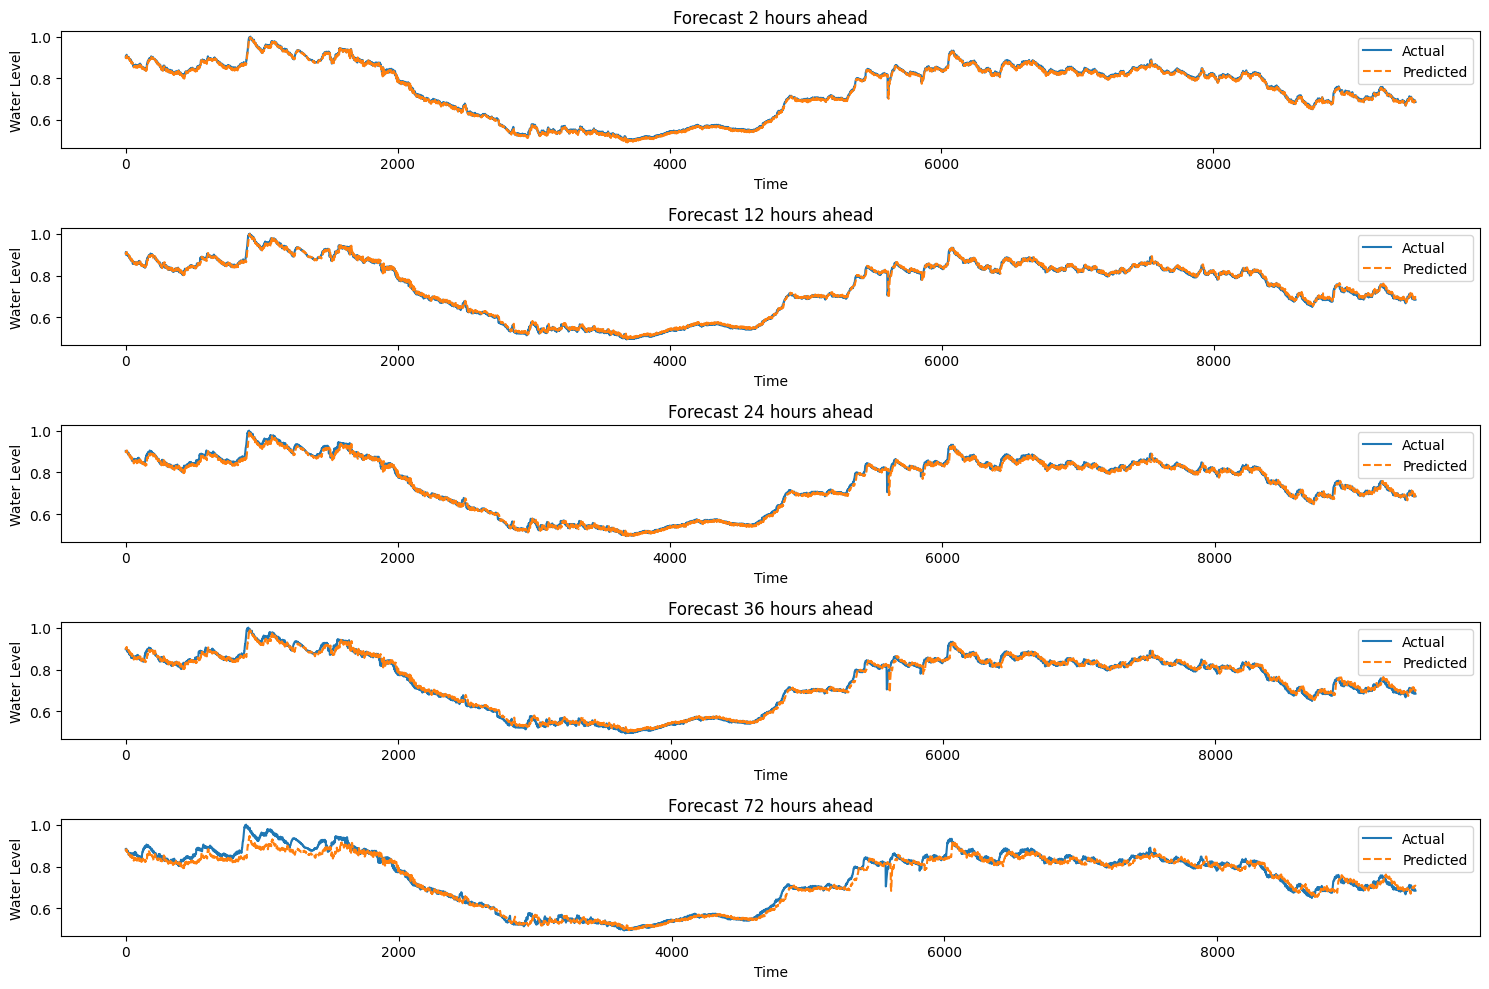

In [18]:
# Plot actual vs predicted values
plt.figure(figsize=(15, 10))
for i, step in enumerate(forecast_steps, 1):
    y_test, y_pred = predictions[step]
    plt.subplot(len(forecast_steps), 1, i)
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted', linestyle='dashed')
    plt.title(f"Forecast {step * time_step} hours ahead")
    plt.xlabel("Time")
    plt.ylabel("Water Level")
    plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# sử dụng dữ liệu 12h
time_step = (df['date'][1] - df['date'][0]).seconds // 3600  # 2 hours
forecast_hours = [2, 12, 24, 36, 72]
forecast_steps = [h // time_step for h in forecast_hours]

n_steps = 6  # 12 hours lookback
split = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:split], scaled_data[split:]

In [7]:
def create_sequences(data, target_col_index, n_steps, forecast_step):
    X, y = [], []
    for i in range(len(data) - n_steps - forecast_step):
        X.append(data[i : i + n_steps])
        y.append(data[i + n_steps + forecast_step, target_col_index])
    return np.array(X), np.array(y)

data_dict = {}
for step in forecast_steps:
    X_train, y_train = create_sequences(train_data, target_col_index=2, n_steps=n_steps, forecast_step=step)
    X_test, y_test = create_sequences(test_data, target_col_index=2, n_steps=n_steps, forecast_step=step)
    data_dict[step] = (X_train, y_train, X_test, y_test)


In [8]:
batch_size = 16
epochs = 20
learning_rate = 0.001
num_units = 64

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(num_units, return_sequences=False, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

models = {}
eval_metrics = {}
predictions = {}

In [9]:
for step, (X_train, y_train, X_test, y_test) in data_dict.items():
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    eval_metrics[step] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}
    models[step] = model
    predictions[step] = (y_test, y_pred)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0084 - val_loss: 4.7007e-05
Epoch 2/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 2.5265e-05 - val_loss: 6.5424e-05
Epoch 3/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 2.7915e-05 - val_loss: 4.9670e-05
Epoch 4/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 2.8749e-05 - val_loss: 1.2849e-04
Epoch 5/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 2.5591e-05 - val_loss: 5.1874e-05
Epoch 6/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 2.4811e-05 - val_loss: 7.9320e-05
Epoch 7/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 2.3251e-05 - val_loss: 4.0487e-05
Epoch 8/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 2.2583e-05 - val_loss: 7.1562e-05
Epoch 9/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 2.1146e-05 - val_loss: 3.9994e-05
Epoch 10/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.9957e-05 - val_loss: 3.0458e-05
Epoch 11/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2375/2375 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0036 - val_loss: 1.4017e-04
Epoch 2/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 4.9843e-05 - val_loss: 8.5592e-05
Epoch 3/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 4.9203e-05 - val_loss: 1.1479e-04
Epoch 4/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 4.8383e-05 - val_loss: 8.3795e-05
Epoch 5/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 4.2422e-05 - val_loss: 1.0322e-04
Epoch 6/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 4.1288e-05 - val_loss: 9.4103e-05
Epoch 7/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 3.8385e-05 - val_loss: 9.2522e-05
Epoch 8/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 3.7298e-05 - val_loss: 9.2809e-05
Epoch 9/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 3.3081e-05 - val_loss: 1.0795e-04
Epoch 10/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 3.3571e-05 - val_loss: 7.1931e-05
Epoch 11/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/ste

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2374/2374 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0042 - val_loss: 1.4583e-04
Epoch 2/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 7.9048e-05 - val_loss: 2.2770e-04
Epoch 3/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 7.4697e-05 - val_loss: 1.6622e-04
Epoch 4/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 7.3675e-05 - val_loss: 1.4404e-04
Epoch 5/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 6.4443e-05 - val_loss: 1.3497e-04
Epoch 6/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 6.2598e-05 - val_loss: 1.5126e-04
Epoch 7/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 5.9497e-05 - val_loss: 1.3097e-04
Epoch 8/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 5.4638e-05 - val_loss: 1.2901e-04
Epoch 9/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 5.2325e-05 - val_loss: 1.2369e-04
Epoch 10/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 4.6747e-05 - val_loss: 1.3091e-04
Epoch 11/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2374/2374 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0071 - val_loss: 2.7182e-04
Epoch 2/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 1.0386e-04 - val_loss: 2.7136e-04
Epoch 3/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.0091e-04 - val_loss: 3.2883e-04
Epoch 4/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.0053e-04 - val_loss: 2.4123e-04
Epoch 5/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 9.2655e-05 - val_loss: 2.0732e-04
Epoch 6/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 8.9000e-05 - val_loss: 2.3088e-04
Epoch 7/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 9.2537e-05 - val_loss: 2.0596e-04
Epoch 8/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 8.5642e-05 - val_loss: 2.2195e-04
Epoch 9/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 8.8137e-05 - val_loss: 2.1212e-04
Epoch 10/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 8.4689e-05 - val_loss: 1.9930e-04
Epoch 11/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/ste

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2373/2373 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0061 - val_loss: 4.8737e-04
Epoch 2/20
2373/2373 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 2.1000e-04 - val_loss: 4.2860e-04
Epoch 3/20
2373/2373 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.9592e-04 - val_loss: 6.0405e-04
Epoch 4/20
2373/2373 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.8675e-04 - val_loss: 4.3775e-04
Epoch 5/20
2373/2373 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.8311e-04 - val_loss: 4.6502e-04
Epoch 6/20
2373/2373 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 1.7699e-04 - val_loss: 4.7968e-04
Epoch 7/20
2373/2373 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 1.7700e-04 - val_loss: 4.3094e-04
Epoch 8/20
2373/2373 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 1.6907e-04 - val_loss: 4.5106e-04
Epoch 9/20
2373/2373 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.6798e-04 - val_loss: 4.3466e-04
Epoch 10/20
2373/2373 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 1.5554e-04 - val_loss: 4.9128e-04
Epoch 11/20
2373/2373 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/ste

In [10]:
# Display results as table
results_df = pd.DataFrame(eval_metrics).T
results_df.index = [f"{step * time_step}h" for step in results_df.index]
print("\nComparison of Forecasting Metrics:")
print(results_df)


Comparison of Forecasting Metrics:
          MSE      RMSE       MAE        R2
2h   0.000027  0.005211  0.003796  0.998407
12h  0.000071  0.008428  0.006022  0.995834
24h  0.000182  0.013489  0.009674  0.989325
36h  0.000229  0.015121  0.011516  0.986582
72h  0.000434  0.020830  0.014415  0.974521


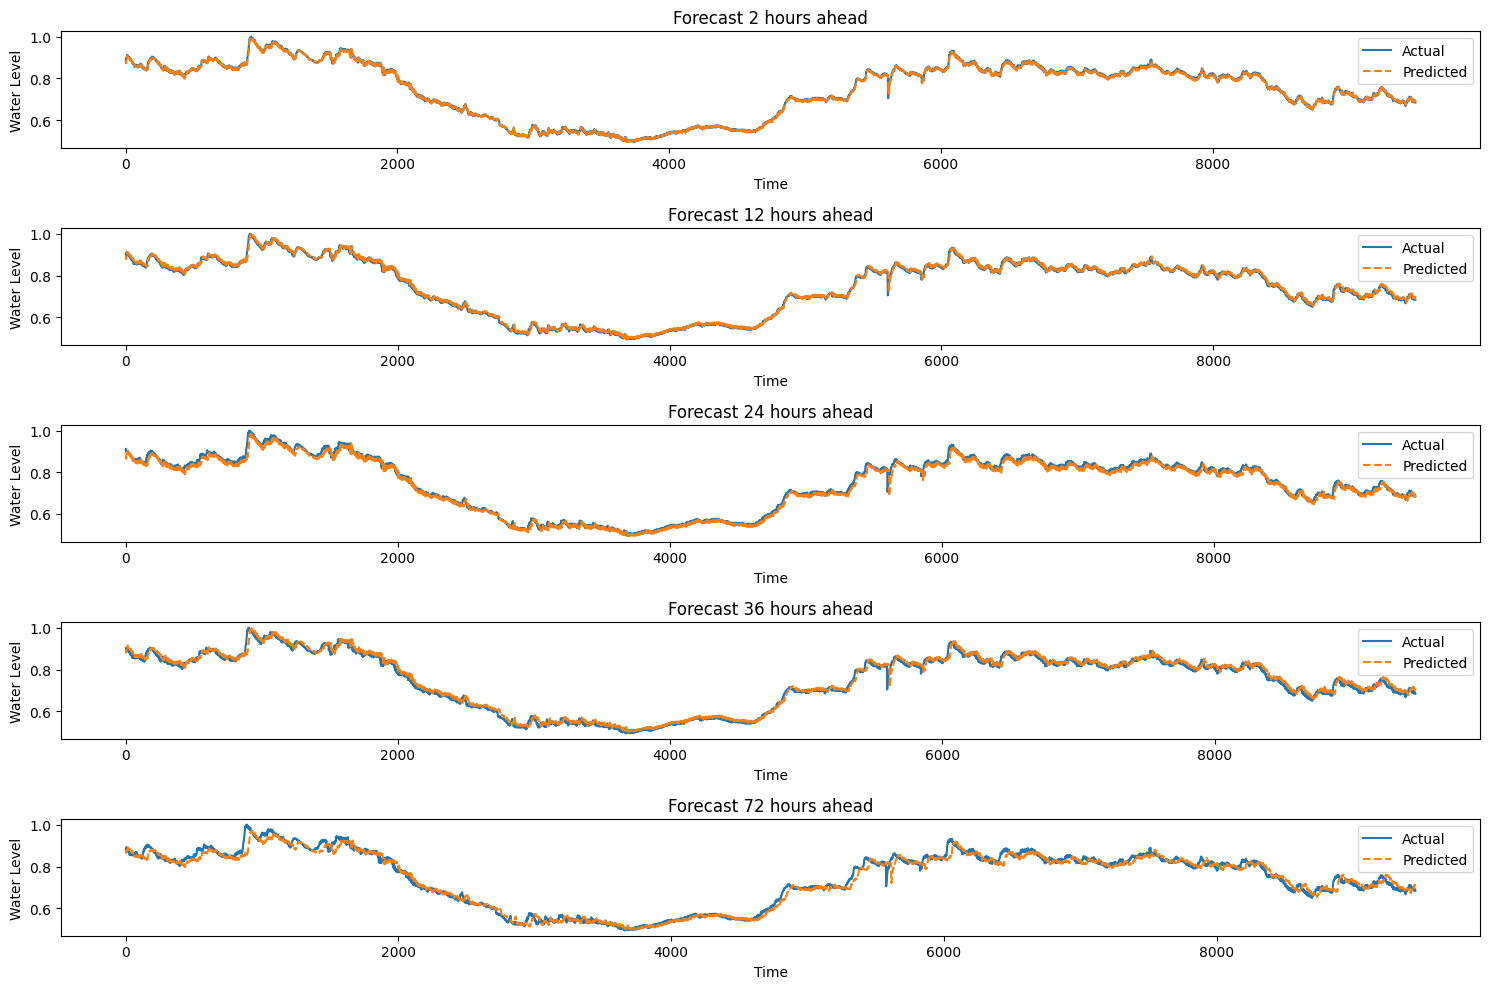

In [11]:
# Plot actual vs predicted values
plt.figure(figsize=(15, 10))
for i, step in enumerate(forecast_steps, 1):
    y_test, y_pred = predictions[step]
    plt.subplot(len(forecast_steps), 1, i)
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted', linestyle='dashed')
    plt.title(f"Forecast {step * time_step} hours ahead")
    plt.xlabel("Time")
    plt.ylabel("Water Level")
    plt.legend()
plt.tight_layout()
plt.show()

In [2]:
# bat dau mo hinh RNN
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

In [3]:
!ls /kaggle/input
df = pd.read_csv("/kaggle/input/mucnuoc/mucnuoc_gio_preprocess.csv")
df.head(3)

mucnuoc  notebook48997725d8


,date,q120,q55,q64,q66,q69
0,2014-01-01 01:00:00,-0.94,-8.00,-4.58,-1.45,-9.01
1,2014-01-01 03:00:00,-0.94,-7.98,-4.57,-1.45,-9.00
2,2014-01-01 05:00:00,-0.94,-7.95,-4.58,-1.45,-9.00


In [4]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date').reset_index(drop=True)

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.iloc[:, 1:])

In [13]:
#RNN 24h
time_step = (df['date'][1] - df['date'][0]).seconds // 3600  # 2 hours
forecast_hours = [2, 12, 24, 36, 72]
forecast_steps = [h // time_step for h in forecast_hours]

n_steps = 12  # 24 hours lookback
split = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:split], scaled_data[split:]

In [14]:
def create_sequences(data, target_col_index, n_steps, forecast_step):
    X, y = [], []
    for i in range(len(data) - n_steps - forecast_step):
        X.append(data[i : i + n_steps])
        y.append(data[i + n_steps + forecast_step, target_col_index])
    return np.array(X), np.array(y)


In [15]:
data_dict = {}
for step in forecast_steps:
    X_train, y_train = create_sequences(train_data, target_col_index=2, n_steps=n_steps, forecast_step=step)
    X_test, y_test = create_sequences(test_data, target_col_index=2, n_steps=n_steps, forecast_step=step)
    data_dict[step] = (X_train, y_train, X_test, y_test)

# Define parameter grid
param_grid = {
    'batch_size': [32, 64],
    'epochs': [10, 20],
    'learning_rate': [0.001, 0.01],
    'num_units': [32, 64],
}

In [16]:
def build_rnn_model(input_shape, num_units, learning_rate):
    model = Sequential()
    model.add(SimpleRNN(num_units, return_sequences=False, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

In [17]:
# Grid search to find best parameters
best_params = None
best_score = float('inf')
for params in ParameterGrid(param_grid):
    batch_size = params['batch_size']
    epochs = params['epochs']
    learning_rate = params['learning_rate']
    num_units = params['num_units']
    
    model = build_rnn_model((n_steps, train_data.shape[1]), num_units, learning_rate)
    X_train, y_train = data_dict[forecast_steps[0]][0:2]  # Use first step for validation
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    
    X_test, y_test = data_dict[forecast_steps[0]][2:4]
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    if mse < best_score:
        best_score = mse
        best_params = params

print("Best Parameters:", best_params)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Best Parameters: {'batch_size': 64, 'epochs': 10, 'learning_rate': 0.01, 'num_units': 32}


In [18]:
# Train final models with best parameters
final_models = {}
eval_metrics = {}
predictions = {}

for step, (X_train, y_train, X_test, y_test) in data_dict.items():
    model = build_rnn_model((X_train.shape[1], X_train.shape[2]), best_params['num_units'], best_params['learning_rate'])
    model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(X_test, y_test), verbose=1)
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    eval_metrics[step] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}
    final_models[step] = model
    predictions[step] = (y_test, y_pred)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


594/594 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0146 - val_loss: 1.0586e-04
Epoch 2/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.7323e-05 - val_loss: 6.2236e-05
Epoch 3/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.2358e-05 - val_loss: 4.7989e-05
Epoch 4/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.1709e-05 - val_loss: 9.0880e-05
Epoch 5/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.5852e-05 - val_loss: 2.2289e-04
Epoch 6/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.0059e-05 - val_loss: 3.3424e-05
Epoch 7/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.1563e-05 - val_loss: 5.4713e-05
Epoch 8/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.7010e-05 - val_loss: 2.8597e-05
Epoch 9/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.8848e-05 - val_loss: 9.4685e-05
Epoch 10/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.9569e-05 - val_loss: 2.6726e-05
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


594/594 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0099 - val_loss: 2.3416e-04
Epoch 2/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.2659e-05 - val_loss: 3.6611e-04
Epoch 3/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.3952e-05 - val_loss: 9.8786e-05
Epoch 4/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.1441e-05 - val_loss: 9.2622e-05
Epoch 5/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.0198e-05 - val_loss: 8.0333e-05
Epoch 6/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.4151e-05 - val_loss: 7.2878e-05
Epoch 7/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.1004e-05 - val_loss: 6.8529e-05
Epoch 8/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.9839e-05 - val_loss: 7.1154e-05
Epoch 9/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.4816e-05 - val_loss: 8.6861e-05
Epoch 10/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.9178e-05 - val_loss: 7.2951e-05
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


594/594 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0179 - val_loss: 2.0039e-04
Epoch 2/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.6462e-05 - val_loss: 5.5786e-04
Epoch 3/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.7721e-05 - val_loss: 1.3394e-04
Epoch 4/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0498e-04 - val_loss: 1.2982e-04
Epoch 5/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0375e-04 - val_loss: 2.3286e-04
Epoch 6/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.3270e-05 - val_loss: 1.1821e-04
Epoch 7/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.0239e-05 - val_loss: 1.2237e-04
Epoch 8/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.5597e-05 - val_loss: 1.2337e-04
Epoch 9/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.4741e-05 - val_loss: 2.3947e-04
Epoch 10/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.1578e-05 - val_loss: 1.2123e-04
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


594/594 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0226 - val_loss: 2.9220e-04
Epoch 2/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.4887e-04 - val_loss: 2.2135e-04
Epoch 3/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1975e-04 - val_loss: 2.7227e-04
Epoch 4/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1525e-04 - val_loss: 2.5766e-04
Epoch 5/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1491e-04 - val_loss: 2.1680e-04
Epoch 6/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0472e-04 - val_loss: 1.9968e-04
Epoch 7/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0356e-04 - val_loss: 2.7963e-04
Epoch 8/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.2121e-05 - val_loss: 2.7926e-04
Epoch 9/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0299e-04 - val_loss: 4.4552e-04
Epoch 10/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0487e-04 - val_loss: 4.6895e-04
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


594/594 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0234 - val_loss: 4.6727e-04
Epoch 2/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.5921e-04 - val_loss: 0.0033
Epoch 3/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.9152e-04 - val_loss: 6.5044e-04
Epoch 4/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.4762e-04 - val_loss: 6.2799e-04
Epoch 5/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.2832e-04 - val_loss: 4.3403e-04
Epoch 6/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.1142e-04 - val_loss: 4.6931e-04
Epoch 7/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.0043e-04 - val_loss: 5.3289e-04
Epoch 8/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.9419e-04 - val_loss: 4.1427e-04
Epoch 9/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.8851e-04 - val_loss: 4.3389e-04
Epoch 10/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.8338e-04 - val_loss: 0.0021
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [19]:
# Display results as table
results_df = pd.DataFrame(eval_metrics).T
results_df.index = [f"{step * time_step}h" for step in results_df.index]
print("\nComparison of Forecasting Metrics:")
print(results_df)


Comparison of Forecasting Metrics:
          MSE      RMSE       MAE        R2
2h   0.000027  0.005170  0.003863  0.998432
12h  0.000073  0.008541  0.005991  0.995720
24h  0.000121  0.011011  0.007324  0.992885
36h  0.000469  0.021655  0.017478  0.972473
72h  0.002129  0.046140  0.042930  0.874976


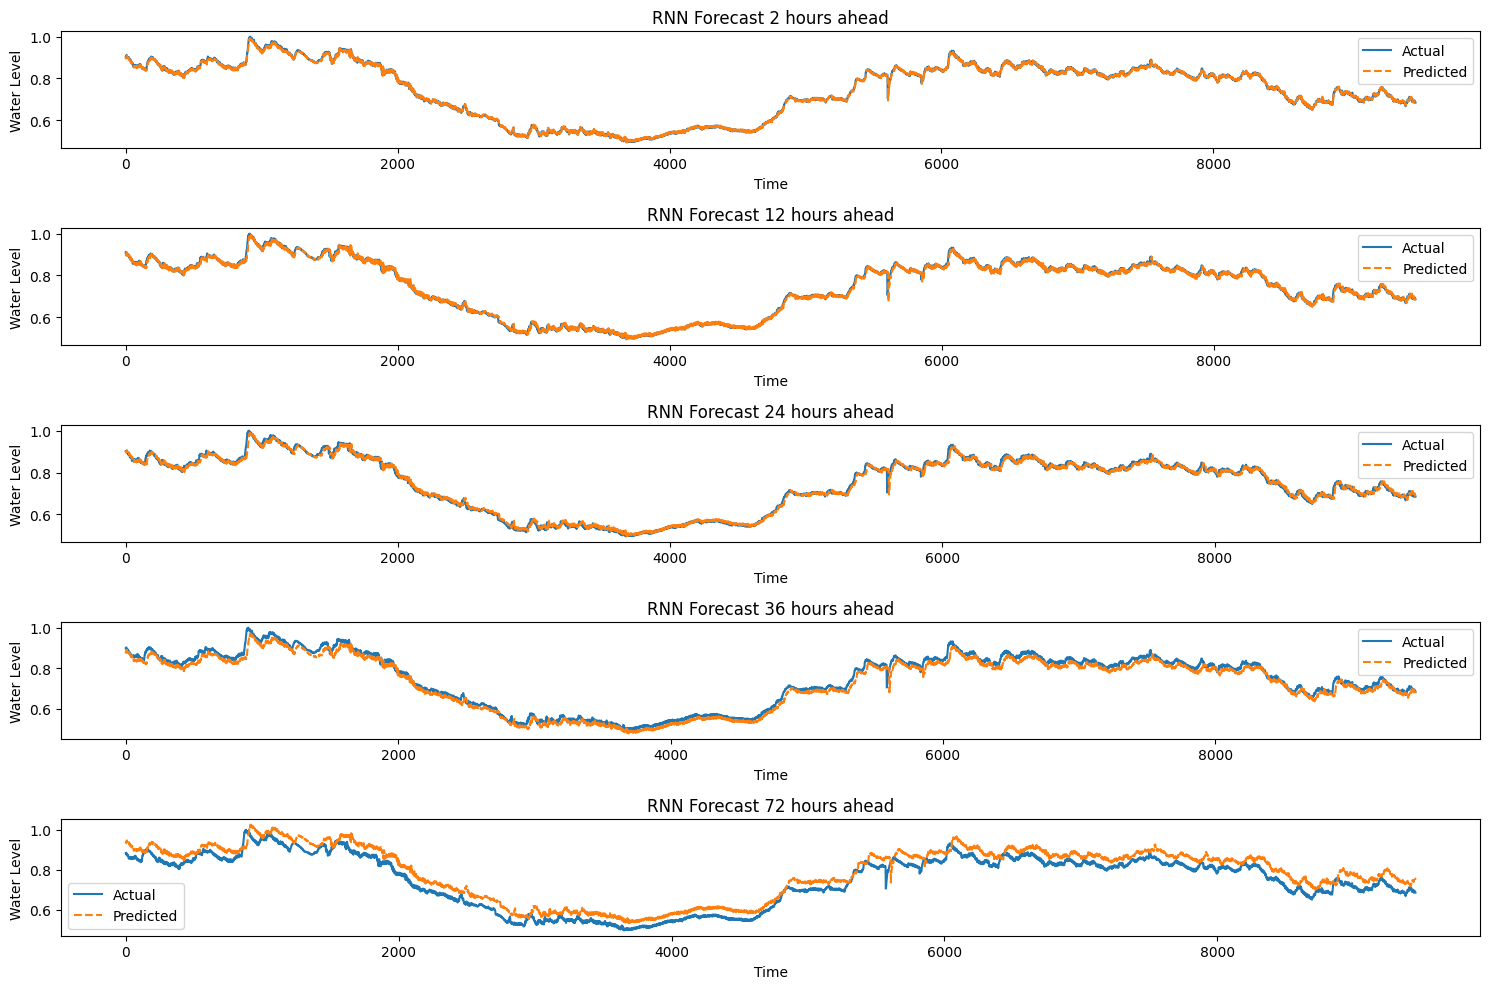

In [21]:
# Plot actual vs predicted values
plt.figure(figsize=(15, 10))
for i, step in enumerate(forecast_steps, 1):
    y_test, y_pred = predictions[step]
    plt.subplot(len(forecast_steps), 1, i)
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted', linestyle='dashed')
    plt.title(f"RNN Forecast {step * time_step} hours ahead")
    plt.xlabel("Time")
    plt.ylabel("Water Level")
    plt.legend()
plt.tight_layout()
plt.show()

In [22]:
#RNN 12h
time_step = (df['date'][1] - df['date'][0]).seconds // 3600  # 2 hours
forecast_hours = [2, 12, 24, 36, 72]
forecast_steps = [h // time_step for h in forecast_hours]

n_steps = 6  # 24 hours lookback
split = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:split], scaled_data[split:]

In [23]:
def create_sequences(data, target_col_index, n_steps, forecast_step):
    X, y = [], []
    for i in range(len(data) - n_steps - forecast_step):
        X.append(data[i : i + n_steps])
        y.append(data[i + n_steps + forecast_step, target_col_index])
    return np.array(X), np.array(y)


In [24]:
data_dict = {}
for step in forecast_steps:
    X_train, y_train = create_sequences(train_data, target_col_index=2, n_steps=n_steps, forecast_step=step)
    X_test, y_test = create_sequences(test_data, target_col_index=2, n_steps=n_steps, forecast_step=step)
    data_dict[step] = (X_train, y_train, X_test, y_test)

# Define parameter grid
param_grid = {
    'batch_size': [32, 64],
    'epochs': [10, 20],
    'learning_rate': [0.001, 0.01],
    'num_units': [32, 64],
}

In [25]:
def build_rnn_model(input_shape, num_units, learning_rate):
    model = Sequential()
    model.add(SimpleRNN(num_units, return_sequences=False, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

In [26]:
# Grid search to find best parameters
best_params = None
best_score = float('inf')
for params in ParameterGrid(param_grid):
    batch_size = params['batch_size']
    epochs = params['epochs']
    learning_rate = params['learning_rate']
    num_units = params['num_units']
    
    model = build_rnn_model((n_steps, train_data.shape[1]), num_units, learning_rate)
    X_train, y_train = data_dict[forecast_steps[0]][0:2]  # Use first step for validation
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    
    X_test, y_test = data_dict[forecast_steps[0]][2:4]
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    if mse < best_score:
        best_score = mse
        best_params = params

print("Best Parameters RNN 12h:", best_params)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Best Parameters RNN 12h: {'batch_size': 64, 'epochs': 20, 'learning_rate': 0.001, 'num_units': 64}


In [27]:
# Train final models with best parameters
final_models = {}
eval_metrics = {}
predictions = {}

for step, (X_train, y_train, X_test, y_test) in data_dict.items():
    model = build_rnn_model((X_train.shape[1], X_train.shape[2]), best_params['num_units'], best_params['learning_rate'])
    model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(X_test, y_test), verbose=1)
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    eval_metrics[step] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}
    final_models[step] = model
    predictions[step] = (y_test, y_pred)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


594/594 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0219 - val_loss: 2.8032e-04
Epoch 2/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1309e-04 - val_loss: 6.6983e-05
Epoch 3/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.3406e-05 - val_loss: 4.6185e-05
Epoch 4/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.9783e-05 - val_loss: 5.3532e-05
Epoch 5/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.8883e-05 - val_loss: 5.2124e-05
Epoch 6/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.2172e-05 - val_loss: 5.5325e-05
Epoch 7/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.2995e-05 - val_loss: 4.1972e-05
Epoch 8/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.9023e-05 - val_loss: 4.1918e-05
Epoch 9/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.6842e-05 - val_loss: 5.3042e-05
Epoch 10/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.2011e-05 - val_loss: 4.3513e-05
Epoch 11/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.6002e-05 - 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


594/594 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0061 - val_loss: 2.4012e-04
Epoch 2/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.8860e-05 - val_loss: 1.4576e-04
Epoch 3/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.9232e-05 - val_loss: 8.6623e-05
Epoch 4/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.8981e-05 - val_loss: 1.3592e-04
Epoch 5/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.5154e-05 - val_loss: 8.0387e-05
Epoch 6/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.1260e-05 - val_loss: 1.1667e-04
Epoch 7/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.6657e-05 - val_loss: 8.0873e-05
Epoch 8/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.5840e-05 - val_loss: 8.5065e-05
Epoch 9/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.4552e-05 - val_loss: 1.9486e-04
Epoch 10/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.0039e-05 - val_loss: 7.4506e-05
Epoch 11/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.1150e-05 - 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


594/594 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0045 - val_loss: 1.6241e-04
Epoch 2/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0085e-04 - val_loss: 1.6041e-04
Epoch 3/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.2715e-05 - val_loss: 2.7188e-04
Epoch 4/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0284e-04 - val_loss: 1.6359e-04
Epoch 5/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.2269e-05 - val_loss: 1.9379e-04
Epoch 6/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.8641e-05 - val_loss: 1.3528e-04
Epoch 7/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.4527e-05 - val_loss: 1.5143e-04
Epoch 8/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.9726e-05 - val_loss: 1.2740e-04
Epoch 9/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.9938e-05 - val_loss: 1.2469e-04
Epoch 10/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.1902e-05 - val_loss: 1.3065e-04
Epoch 11/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.7696e-05 - 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


594/594 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0186 - val_loss: 4.1820e-04
Epoch 2/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6188e-04 - val_loss: 2.9063e-04
Epoch 3/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1936e-04 - val_loss: 2.5667e-04
Epoch 4/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0668e-04 - val_loss: 2.5230e-04
Epoch 5/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.2085e-04 - val_loss: 2.2882e-04
Epoch 6/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1118e-04 - val_loss: 2.3855e-04
Epoch 7/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.2088e-04 - val_loss: 2.3606e-04
Epoch 8/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1839e-04 - val_loss: 2.3996e-04
Epoch 9/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0289e-04 - val_loss: 2.3167e-04
Epoch 10/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0653e-04 - val_loss: 4.2259e-04
Epoch 11/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.4827e-05 - 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


594/594 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0240 - val_loss: 8.2061e-04
Epoch 2/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.4430e-04 - val_loss: 4.6365e-04
Epoch 3/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.0131e-04 - val_loss: 5.6962e-04
Epoch 4/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.8800e-04 - val_loss: 4.5588e-04
Epoch 5/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.9187e-04 - val_loss: 4.2008e-04
Epoch 6/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.8784e-04 - val_loss: 4.5517e-04
Epoch 7/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.8342e-04 - val_loss: 4.3965e-04
Epoch 8/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.7763e-04 - val_loss: 4.6898e-04
Epoch 9/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.1428e-04 - val_loss: 4.3699e-04
Epoch 10/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.7611e-04 - val_loss: 0.0016
Epoch 11/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.2151e-04 - val_

In [28]:
# Display results as table
results_df = pd.DataFrame(eval_metrics).T
results_df.index = [f"{step * time_step}h" for step in results_df.index]
print("\nComparison of Forecasting Metrics:")
print(results_df)


Comparison of Forecasting Metrics:
          MSE      RMSE       MAE        R2
2h   0.000102  0.010112  0.008623  0.994003
12h  0.000142  0.011904  0.009515  0.991688
24h  0.000127  0.011260  0.008037  0.992561
36h  0.000208  0.014420  0.009931  0.987798
72h  0.000486  0.022050  0.017167  0.971450


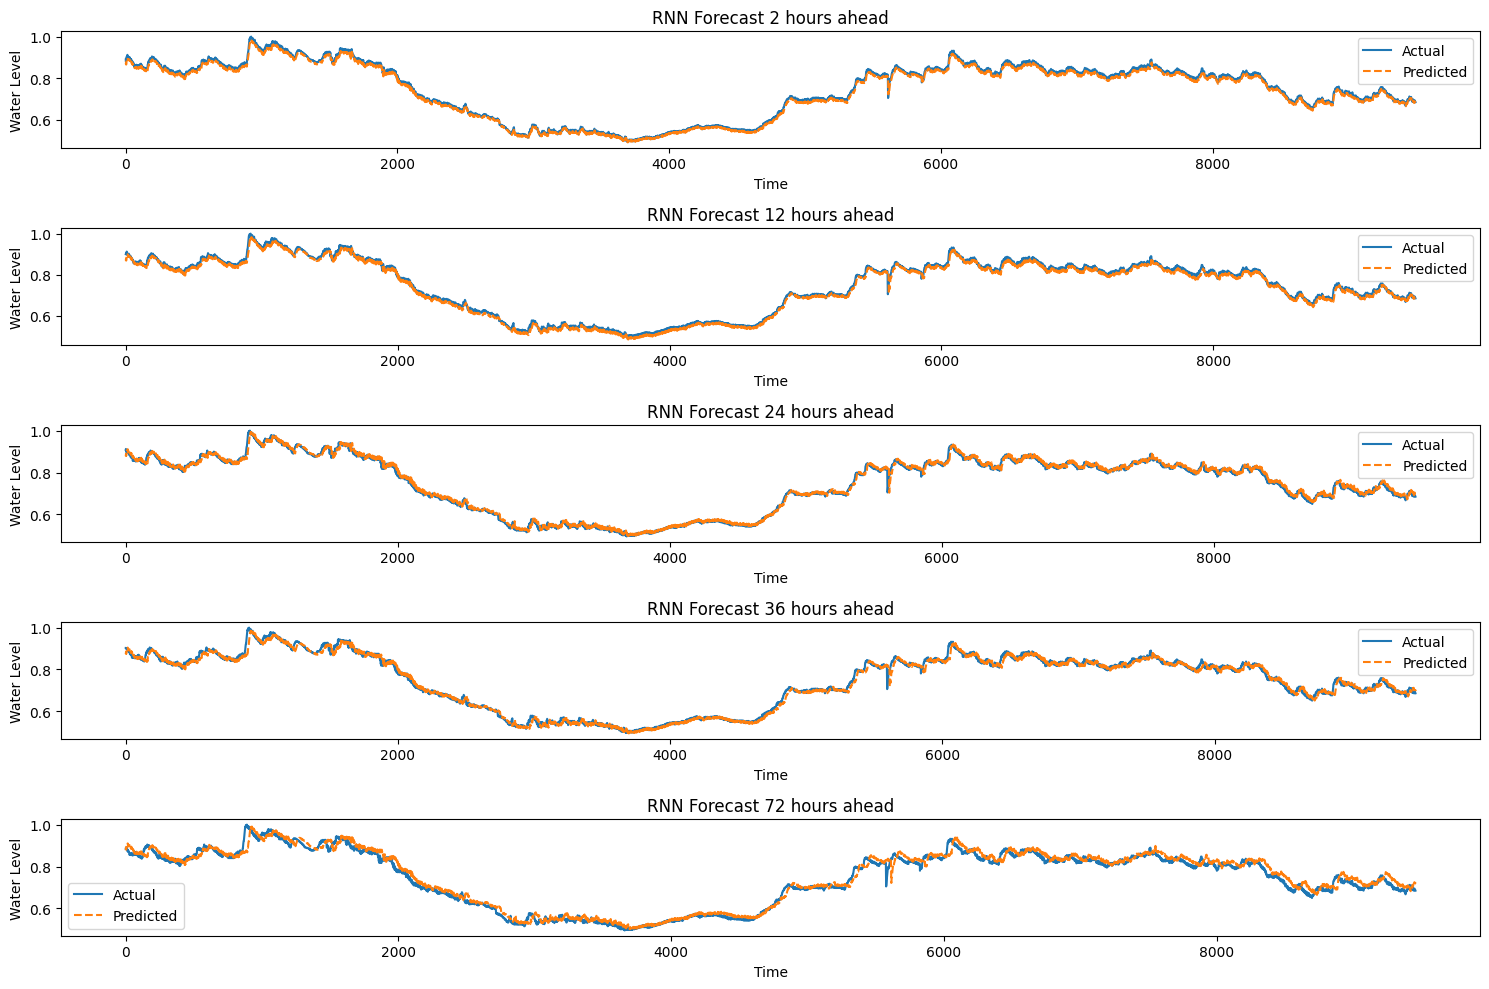

In [29]:
# Plot actual vs predicted values
plt.figure(figsize=(15, 10))
for i, step in enumerate(forecast_steps, 1):
    y_test, y_pred = predictions[step]
    plt.subplot(len(forecast_steps), 1, i)
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted', linestyle='dashed')
    plt.title(f"RNN Forecast {step * time_step} hours ahead")
    plt.xlabel("Time")
    plt.ylabel("Water Level")
    plt.legend()
plt.tight_layout()
plt.show()

In [1]:
# Transformer Forecasting for Water Level at Station Q64 with Grid Search

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

In [2]:
!ls /kaggle/input
df = pd.read_csv("/kaggle/input/mucnuoc/mucnuoc_gio_preprocess.csv")
df.head(3)

mucnuoc  notebook48997725d8


,date,q120,q55,q64,q66,q69
0,2014-01-01 01:00:00,-0.94,-8.00,-4.58,-1.45,-9.01
1,2014-01-01 03:00:00,-0.94,-7.98,-4.57,-1.45,-9.00
2,2014-01-01 05:00:00,-0.94,-7.95,-4.58,-1.45,-9.00


In [3]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date').reset_index(drop=True)

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.iloc[:, 1:])

time_step = (df['date'][1] - df['date'][0]).seconds // 3600  # 2 hours
forecast_hours = [2, 12, 24, 36, 72]
forecast_steps = [h // time_step for h in forecast_hours]


In [4]:
#transformer 24h
n_steps = 12  # 24 hours lookback
split = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:split], scaled_data[split:]

def create_sequences(data, target_col_index, n_steps, forecast_step):
    X, y = [], []
    for i in range(len(data) - n_steps - forecast_step):
        X.append(data[i : i + n_steps])
        y.append(data[i + n_steps + forecast_step, target_col_index])
    return np.array(X), np.array(y)

In [5]:
data_dict = {}
for step in forecast_steps:
    X_train, y_train = create_sequences(train_data, target_col_index=2, n_steps=n_steps, forecast_step=step)
    X_test, y_test = create_sequences(test_data, target_col_index=2, n_steps=n_steps, forecast_step=step)
    data_dict[step] = (X_train, y_train, X_test, y_test)

In [6]:
# Define parameter grid
param_grid = {
    'batch_size': [16, 32],
    'epochs': [10, 20],
    'learning_rate': [0.001, 0.0001],
    'num_heads': [4, 8],
    'ff_dim': [64, 128],
}

def build_transformer_model(input_shape, num_heads, ff_dim, learning_rate):
    inputs = Input(shape=input_shape)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(inputs, inputs)
    attn_output = Dropout(0.1)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)
    ffn_output = Dense(ff_dim, activation="relu")(out1)
    ffn_output = Dense(input_shape[-1])(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)
    avg_pool = GlobalAveragePooling1D()(out2)
    outputs = Dense(1)(avg_pool)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

In [7]:
# Grid search to find best parameters
best_params = None
best_score = float('inf')
for params in ParameterGrid(param_grid):
    batch_size = params['batch_size']
    epochs = params['epochs']
    learning_rate = params['learning_rate']
    num_heads = params['num_heads']
    ff_dim = params['ff_dim']
    
    model = build_transformer_model((n_steps, train_data.shape[1]), num_heads, ff_dim, learning_rate)
    X_train, y_train = data_dict[forecast_steps[0]][0:2]  # Use first step for validation
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    
    X_test, y_test = data_dict[forecast_steps[0]][2:4]
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    if mse < best_score:
        best_score = mse
        best_params = params

print("Best Parameters:", best_params)

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━

In [8]:
# Train final models with best parameters
final_models = {}
eval_metrics = {}
predictions = {}

for step, (X_train, y_train, X_test, y_test) in data_dict.items():
    model = build_transformer_model((X_train.shape[1], X_train.shape[2]), best_params['num_heads'], best_params['ff_dim'], best_params['learning_rate'])
    model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(X_test, y_test), verbose=1)
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    eval_metrics[step] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}
    final_models[step] = model
    predictions[step] = (y_test, y_pred)

Epoch 1/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0232 - val_loss: 0.0011
Epoch 2/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.8662e-04 - val_loss: 5.2303e-04
Epoch 3/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.9160e-04 - val_loss: 4.8613e-04
Epoch 4/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.5733e-04 - val_loss: 2.0794e-04
Epoch 5/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.5354e-04 - val_loss: 5.9371e-04
Epoch 6/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.4536e-04 - val_loss: 0.0030
Epoch 7/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.4942e-04 - val_loss: 3.7036e-04
Epoch 8/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.2435e-04 - val_loss: 0.0011
Epoch 9/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.1212e-04 - val_loss: 7.5453e-04
Epoch 10/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.1804e-04 - val_loss: 0.0012
Epoch 11/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lo

In [9]:
# Display results as table
results_df = pd.DataFrame(eval_metrics).T
results_df.index = [f"{step * time_step}h" for step in results_df.index]
print("\nComparison of Forecasting Metrics:")
print(results_df)


Comparison of Forecasting Metrics:
          MSE      RMSE       MAE        R2
2h   0.000648  0.025461  0.022360  0.961975
12h  0.000195  0.013956  0.011024  0.988573
24h  0.000518  0.022753  0.017560  0.969618
36h  0.001219  0.034909  0.030328  0.928467
72h  0.001468  0.038313  0.031801  0.913794


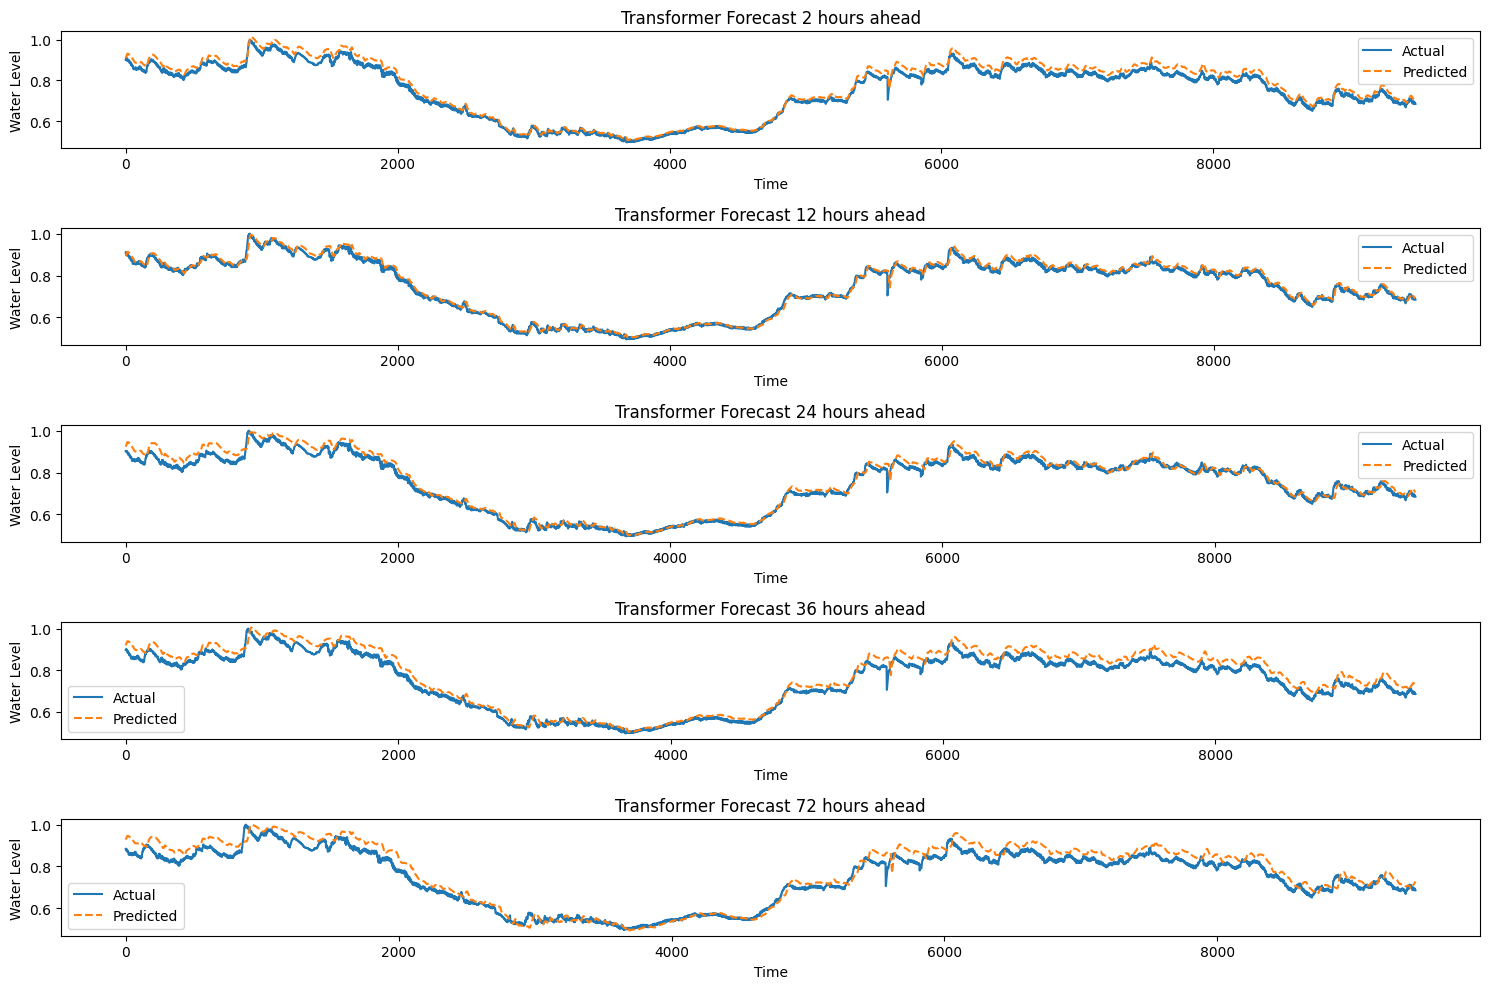

In [10]:
# Plot actual vs predicted values
plt.figure(figsize=(15, 10))
for i, step in enumerate(forecast_steps, 1):
    y_test, y_pred = predictions[step]
    plt.subplot(len(forecast_steps), 1, i)
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted', linestyle='dashed')
    plt.title(f"Transformer Forecast {step * time_step} hours ahead")
    plt.xlabel("Time")
    plt.ylabel("Water Level")
    plt.legend()
plt.tight_layout()
plt.show()

In [11]:
#transformer 12h
n_steps = 6  # 12 hours lookback
split = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:split], scaled_data[split:]

def create_sequences(data, target_col_index, n_steps, forecast_step):
    X, y = [], []
    for i in range(len(data) - n_steps - forecast_step):
        X.append(data[i : i + n_steps])
        y.append(data[i + n_steps + forecast_step, target_col_index])
    return np.array(X), np.array(y)

In [12]:
data_dict = {}
for step in forecast_steps:
    X_train, y_train = create_sequences(train_data, target_col_index=2, n_steps=n_steps, forecast_step=step)
    X_test, y_test = create_sequences(test_data, target_col_index=2, n_steps=n_steps, forecast_step=step)
    data_dict[step] = (X_train, y_train, X_test, y_test)

In [13]:
# Define parameter grid
param_grid = {
    'batch_size': [16, 32],
    'epochs': [10, 20],
    'learning_rate': [0.001, 0.0001],
    'num_heads': [4, 8],
    'ff_dim': [64, 128],
}

def build_transformer_model(input_shape, num_heads, ff_dim, learning_rate):
    inputs = Input(shape=input_shape)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(inputs, inputs)
    attn_output = Dropout(0.1)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)
    ffn_output = Dense(ff_dim, activation="relu")(out1)
    ffn_output = Dense(input_shape[-1])(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)
    avg_pool = GlobalAveragePooling1D()(out2)
    outputs = Dense(1)(avg_pool)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

In [14]:
# Grid search to find best parameters
best_params = None
best_score = float('inf')
for params in ParameterGrid(param_grid):
    batch_size = params['batch_size']
    epochs = params['epochs']
    learning_rate = params['learning_rate']
    num_heads = params['num_heads']
    ff_dim = params['ff_dim']
    
    model = build_transformer_model((n_steps, train_data.shape[1]), num_heads, ff_dim, learning_rate)
    X_train, y_train = data_dict[forecast_steps[0]][0:2]  # Use first step for validation
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    
    X_test, y_test = data_dict[forecast_steps[0]][2:4]
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    if mse < best_score:
        best_score = mse
        best_params = params

print("Best Parameters:", best_params)

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━

In [15]:
# Train final models with best parameters
final_models = {}
eval_metrics = {}
predictions = {}

for step, (X_train, y_train, X_test, y_test) in data_dict.items():
    model = build_transformer_model((X_train.shape[1], X_train.shape[2]), best_params['num_heads'], best_params['ff_dim'], best_params['learning_rate'])
    model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(X_test, y_test), verbose=1)
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    eval_metrics[step] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}
    final_models[step] = model
    predictions[step] = (y_test, y_pred)

Epoch 1/10
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0290 - val_loss: 0.0015
Epoch 2/10
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 4.5144e-04 - val_loss: 8.1157e-04
Epoch 3/10
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 3.4940e-04 - val_loss: 0.0023
Epoch 4/10
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 2.8359e-04 - val_loss: 0.0023
Epoch 5/10
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 2.4365e-04 - val_loss: 0.0013
Epoch 6/10
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.9633e-04 - val_loss: 5.8696e-05
Epoch 7/10
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.6218e-04 - val_loss: 2.6625e-04
Epoch 8/10
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.3837e-04 - val_loss: 1.4524e-04
Epoch 9/10
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.4160e-04 - val_loss: 0.0023
Epoch 10/10
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.3628e-04 - val_loss: 2.5981e-04
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10
2375/2375 

In [16]:
# Display results as table
results_df = pd.DataFrame(eval_metrics).T
results_df.index = [f"{step * time_step}h" for step in results_df.index]
print("\nComparison of Forecasting Metrics:")
print(results_df)


Comparison of Forecasting Metrics:
          MSE      RMSE       MAE        R2
2h   0.000260  0.016119  0.013476  0.984762
12h  0.000431  0.020761  0.017190  0.974719
24h  0.000183  0.013537  0.010189  0.989249
36h  0.000939  0.030637  0.026444  0.944917
72h  0.000773  0.027802  0.022694  0.954611


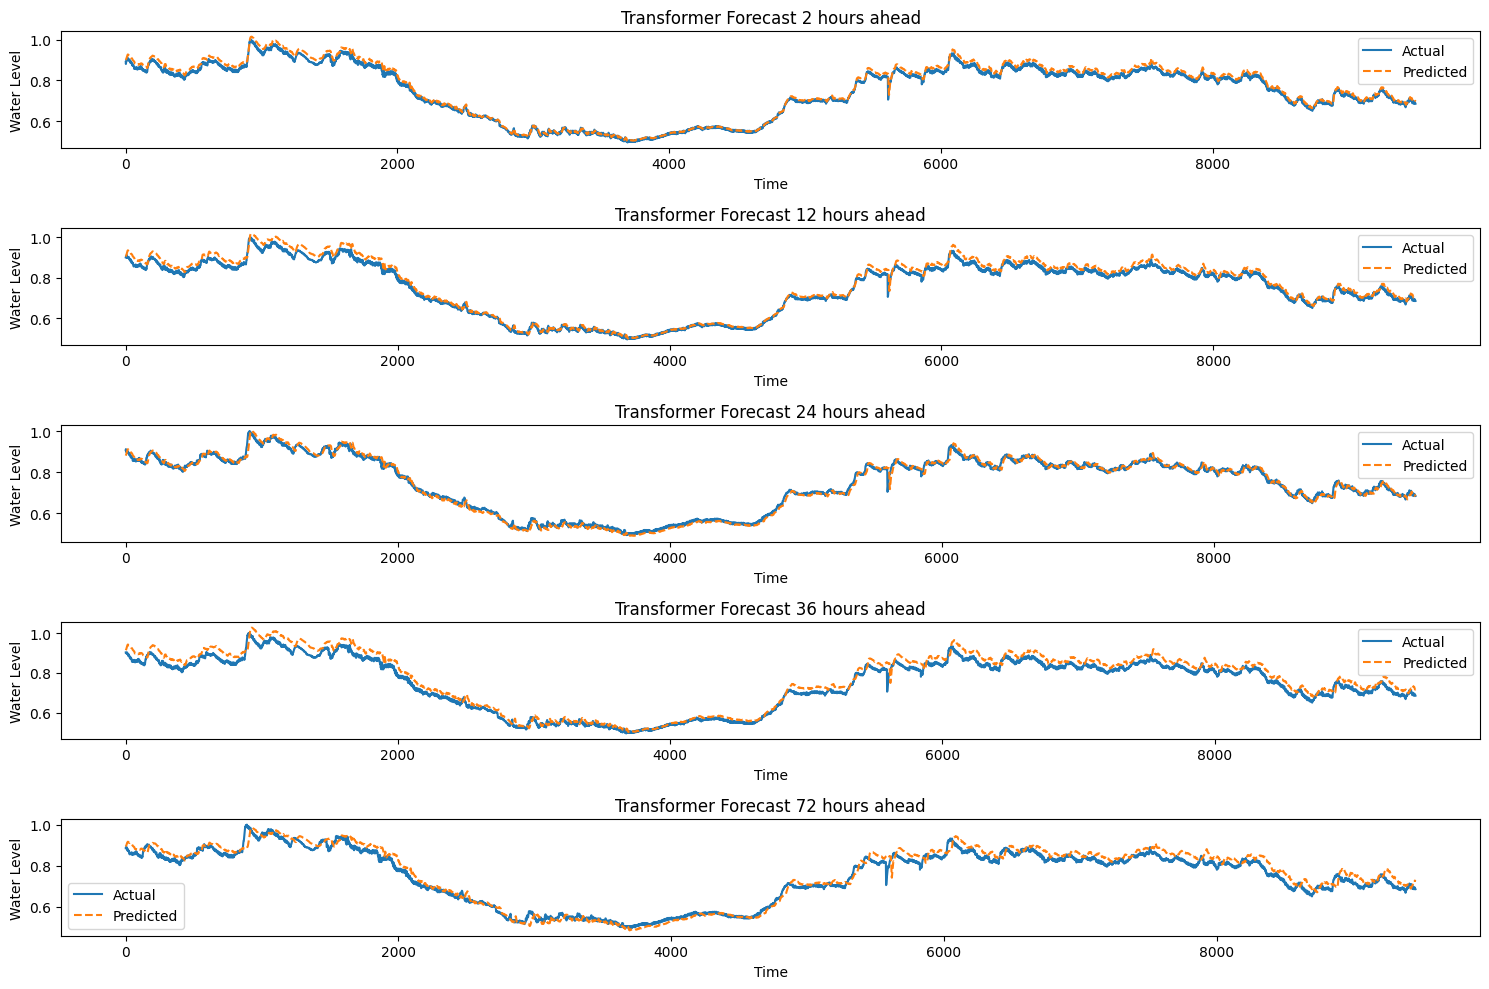

In [17]:
# Plot actual vs predicted values
plt.figure(figsize=(15, 10))
for i, step in enumerate(forecast_steps, 1):
    y_test, y_pred = predictions[step]
    plt.subplot(len(forecast_steps), 1, i)
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted', linestyle='dashed')
    plt.title(f"Transformer Forecast {step * time_step} hours ahead")
    plt.xlabel("Time")
    plt.ylabel("Water Level")
    plt.legend()
plt.tight_layout()
plt.show()

In [30]:
# Autoformer Forecasting for Water Level at Station Q64 with Grid Search

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

In [31]:
!ls /kaggle/input
df = pd.read_csv("/kaggle/input/mucnuoc/mucnuoc_gio_preprocess.csv")
df.head(3)

mucnuoc  notebook48997725d8


,date,q120,q55,q64,q66,q69
0,2014-01-01 01:00:00,-0.94,-8.00,-4.58,-1.45,-9.01
1,2014-01-01 03:00:00,-0.94,-7.98,-4.57,-1.45,-9.00
2,2014-01-01 05:00:00,-0.94,-7.95,-4.58,-1.45,-9.00


In [35]:
#Autoformer 24h
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date').reset_index(drop=True)

# Feature engineering: adding lag features, rolling mean, and volatility
df['lag_1'] = df['q64'].shift(1)
df['lag_2'] = df['q64'].shift(2)
df['rolling_mean_3'] = df['q64'].rolling(window=3).mean()
df['rolling_mean_5'] = df['q64'].rolling(window=5).mean()
df['volatility'] = df['q64'].rolling(window=3).std()
df.fillna(method="bfill", inplace=True)

<ipython-input-35-e004680f9f02>:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


In [36]:
# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.iloc[:, 1:])

time_step = (df['date'][1] - df['date'][0]).seconds // 3600  # 2 hours
forecast_hours = [2, 12, 24, 36, 72]
forecast_steps = [h // time_step for h in forecast_hours]

n_steps = 12  # 24 hours lookback
split = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:split], scaled_data[split:]

In [37]:
def create_sequences(data, target_col_index, n_steps, forecast_step):
    X, y = [], []
    for i in range(len(data) - n_steps - forecast_step):
        X.append(data[i : i + n_steps])
        y.append(data[i + n_steps + forecast_step, target_col_index])
    return np.array(X), np.array(y)

data_dict = {}
for step in forecast_steps:
    X_train, y_train = create_sequences(train_data, target_col_index=2, n_steps=n_steps, forecast_step=step)
    X_test, y_test = create_sequences(test_data, target_col_index=2, n_steps=n_steps, forecast_step=step)
    data_dict[step] = (X_train, y_train, X_test, y_test)


In [43]:
# Define parameter grid
param_grid = {
    'batch_size': [16, 32],
    'epochs': [10, 20],
    'learning_rate': [0.001, 0.0005],
    'num_heads': [4, 8],
    'ff_dim': [10],
}

def build_autoformer_model(input_shape, num_heads, ff_dim, learning_rate):
    inputs = Input(shape=input_shape)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(inputs, inputs)
    attn_output = Dropout(0.1)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)
    conv_output = Conv1D(filters=ff_dim, kernel_size=3, padding='same', activation="relu")(out1)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + conv_output)
    avg_pool = GlobalAveragePooling1D()(out2)
    outputs = Dense(1)(avg_pool)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

In [44]:
# Grid search to find best parameters
best_params = None
best_score = float('inf')
for params in ParameterGrid(param_grid):
    batch_size = params['batch_size']
    epochs = params['epochs']
    learning_rate = params['learning_rate']
    num_heads = params['num_heads']
    ff_dim = params['ff_dim']
    
    model = build_autoformer_model((n_steps, train_data.shape[1]), num_heads, ff_dim, learning_rate)
    X_train, y_train = data_dict[forecast_steps[0]][0:2]  # Use first step for validation
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    
    X_test, y_test = data_dict[forecast_steps[0]][2:4]
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    if mse < best_score:
        best_score = mse
        best_params = params

print("Best Parameters:", best_params)

297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Best Parameters: {'batch_size': 16, 'epochs': 20, 'ff_dim': 10, 'learning_rate': 0.0005, 'num_heads': 4}


In [45]:
# Train final models with best parameters
final_models = {}
eval_metrics = {}
predictions = {}

for step, (X_train, y_train, X_test, y_test) in data_dict.items():
    model = build_autoformer_model((X_train.shape[1], X_train.shape[2]), best_params['num_heads'], best_params['ff_dim'], best_params['learning_rate'])
    model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(X_test, y_test), verbose=1)
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    eval_metrics[step] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}
    final_models[step] = model
    predictions[step] = (y_test, y_pred)

Epoch 1/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0348 - val_loss: 0.0017
Epoch 2/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 8.4401e-04 - val_loss: 7.0118e-04
Epoch 3/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3.4143e-04 - val_loss: 4.1382e-04
Epoch 4/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 2.0208e-04 - val_loss: 3.7273e-04
Epoch 5/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.6905e-04 - val_loss: 2.6206e-04
Epoch 6/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.3508e-04 - val_loss: 3.5654e-04
Epoch 7/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.1245e-04 - val_loss: 2.0705e-04
Epoch 8/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.0572e-04 - val_loss: 2.6408e-04
Epoch 9/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 9.8515e-05 - val_loss: 2.4112e-04
Epoch 10/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 8.9888e-05 - val_loss: 1.7864e-04
Epoch 11/20
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 5s 

In [46]:
# Display results as table
results_df = pd.DataFrame(eval_metrics).T
results_df.index = [f"{step * time_step}h" for step in results_df.index]
print("\nComparison of Forecasting Metrics:")
print(results_df)


Comparison of Forecasting Metrics:
          MSE      RMSE       MAE        R2
2h   0.000112  0.010564  0.007925  0.993451
12h  0.001233  0.035109  0.031759  0.927647
24h  0.000418  0.020455  0.015075  0.975434
36h  0.000516  0.022711  0.016046  0.969713
72h  0.001046  0.032349  0.022064  0.938542


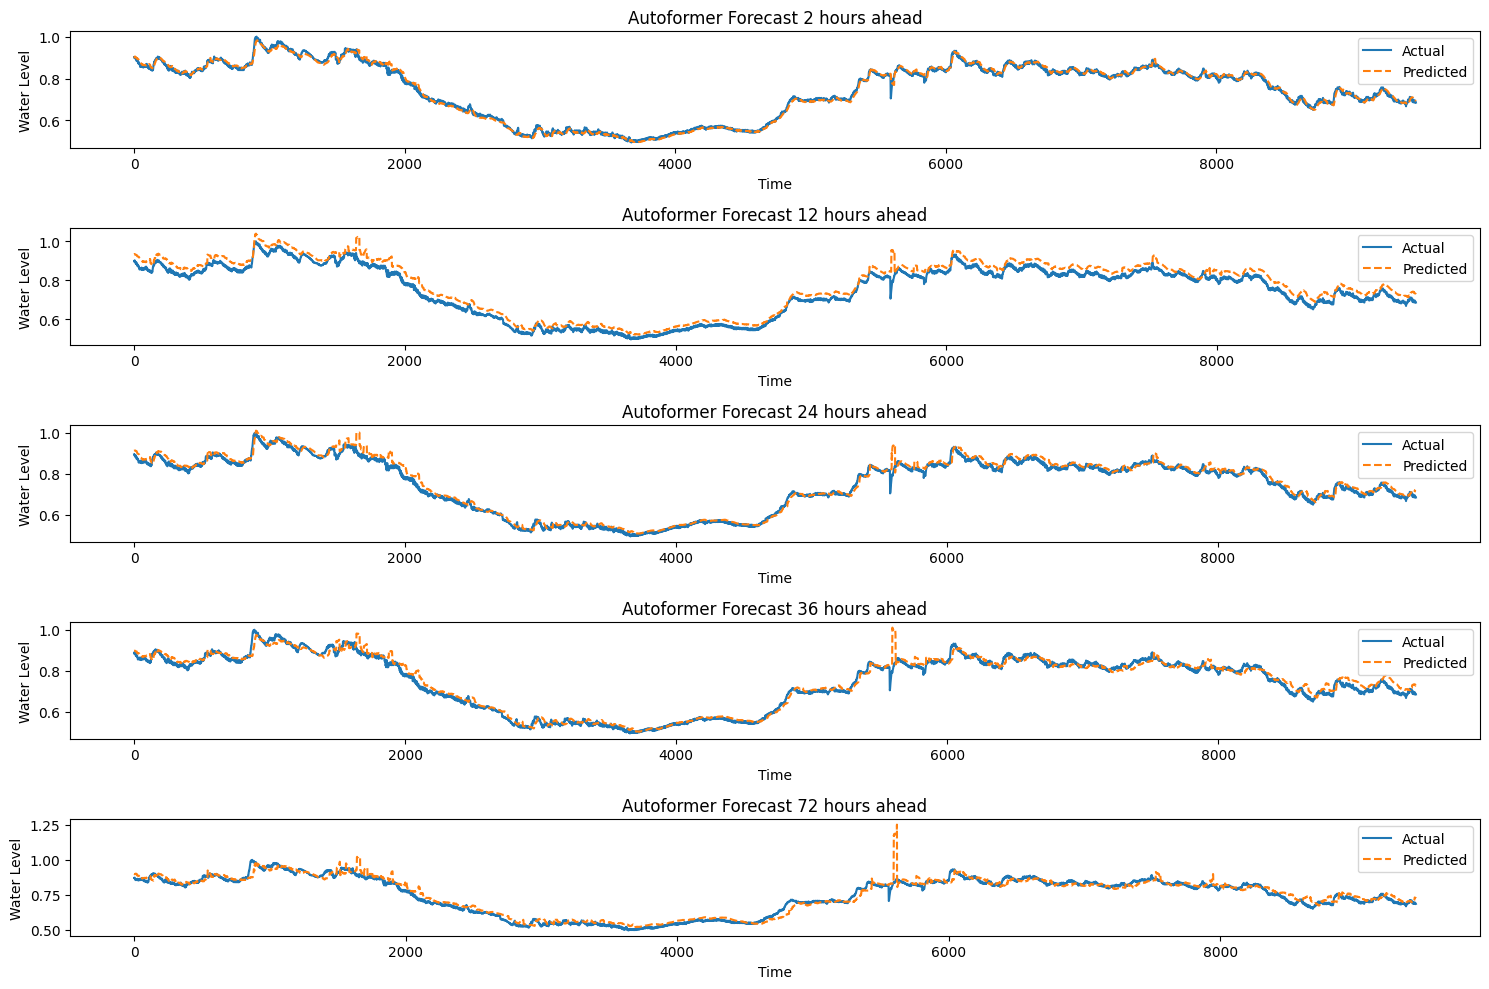

In [47]:
# Plot actual vs predicted values
plt.figure(figsize=(15, 10))
for i, step in enumerate(forecast_steps, 1):
    y_test, y_pred = predictions[step]
    plt.subplot(len(forecast_steps), 1, i)
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted', linestyle='dashed')
    plt.title(f"Autoformer Forecast {step * time_step} hours ahead")
    plt.xlabel("Time")
    plt.ylabel("Water Level")
    plt.legend()
plt.tight_layout()
plt.show()

In [50]:
#Autoformer 12h
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date').reset_index(drop=True)

# Feature engineering: adding lag features, rolling mean, and volatility
df['lag_1'] = df['q64'].shift(1)
df['lag_2'] = df['q64'].shift(2)
df['rolling_mean_3'] = df['q64'].rolling(window=3).mean()
df['rolling_mean_5'] = df['q64'].rolling(window=5).mean()
df['volatility'] = df['q64'].rolling(window=3).std()
df.fillna(method="bfill", inplace=True)

<ipython-input-50-b47508814efa>:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


In [51]:

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.iloc[:, 1:])

time_step = (df['date'][1] - df['date'][0]).seconds // 3600  # 2 hours
forecast_hours = [2, 12, 24, 36, 72]
forecast_steps = [h // time_step for h in forecast_hours]

n_steps = 6  # 12 hours lookback
split = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:split], scaled_data[split:]

In [52]:
def create_sequences(data, target_col_index, n_steps, forecast_step):
    X, y = [], []
    for i in range(len(data) - n_steps - forecast_step):
        X.append(data[i : i + n_steps])
        y.append(data[i + n_steps + forecast_step, target_col_index])
    return np.array(X), np.array(y)

data_dict = {}
for step in forecast_steps:
    X_train, y_train = create_sequences(train_data, target_col_index=2, n_steps=n_steps, forecast_step=step)
    X_test, y_test = create_sequences(test_data, target_col_index=2, n_steps=n_steps, forecast_step=step)
    data_dict[step] = (X_train, y_train, X_test, y_test)


In [53]:
# Define parameter grid
param_grid = {
    'batch_size': [16, 32],
    'epochs': [10, 20],
    'learning_rate': [0.001, 0.0005],
    'num_heads': [4, 8],
    'ff_dim': [10],
}

def build_autoformer_model(input_shape, num_heads, ff_dim, learning_rate):
    inputs = Input(shape=input_shape)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(inputs, inputs)
    attn_output = Dropout(0.1)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)
    conv_output = Conv1D(filters=ff_dim, kernel_size=3, padding='same', activation="relu")(out1)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + conv_output)
    avg_pool = GlobalAveragePooling1D()(out2)
    outputs = Dense(1)(avg_pool)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

In [54]:
# Grid search to find best parameters
best_params = None
best_score = float('inf')
for params in ParameterGrid(param_grid):
    batch_size = params['batch_size']
    epochs = params['epochs']
    learning_rate = params['learning_rate']
    num_heads = params['num_heads']
    ff_dim = params['ff_dim']
    
    model = build_autoformer_model((n_steps, train_data.shape[1]), num_heads, ff_dim, learning_rate)
    X_train, y_train = data_dict[forecast_steps[0]][0:2]  # Use first step for validation
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    
    X_test, y_test = data_dict[forecast_steps[0]][2:4]
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    if mse < best_score:
        best_score = mse
        best_params = params

print("Best Parameters:", best_params)

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Best Parameters: {'batch_size': 16, 'epochs': 20, 'ff_dim': 10, 'learning_rate': 0.0005, 'num_heads': 4}


In [55]:
# Train final models with best parameters
final_models = {}
eval_metrics = {}
predictions = {}

for step, (X_train, y_train, X_test, y_test) in data_dict.items():
    model = build_autoformer_model((X_train.shape[1], X_train.shape[2]), best_params['num_heads'], best_params['ff_dim'], best_params['learning_rate'])
    model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(X_test, y_test), verbose=1)
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    eval_metrics[step] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}
    final_models[step] = model
    predictions[step] = (y_test, y_pred)

Epoch 1/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0771 - val_loss: 0.0041
Epoch 2/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0017 - val_loss: 7.9131e-04
Epoch 3/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 5.3674e-04 - val_loss: 2.1400e-04
Epoch 4/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.9497e-04 - val_loss: 2.0828e-04
Epoch 5/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.0448e-04 - val_loss: 5.9199e-04
Epoch 6/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.6531e-04 - val_loss: 4.3446e-04
Epoch 7/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.3707e-04 - val_loss: 1.1466e-04
Epoch 8/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.1918e-04 - val_loss: 1.3550e-04
Epoch 9/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.0691e-04 - val_loss: 1.5857e-04
Epoch 10/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 9.7977e-05 - val_loss: 3.0529e-04
Epoch 11/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/

In [56]:
# Display results as table
results_df = pd.DataFrame(eval_metrics).T
results_df.index = [f"{step * time_step}h" for step in results_df.index]
print("\nComparison of Forecasting Metrics:")
print(results_df)


Comparison of Forecasting Metrics:
          MSE      RMSE       MAE        R2
2h   0.000135  0.011621  0.008772  0.992079
12h  0.000243  0.015596  0.011554  0.985734
24h  0.000349  0.018690  0.015590  0.979507
36h  0.000332  0.018220  0.014292  0.980518
72h  0.000580  0.024083  0.017849  0.965942


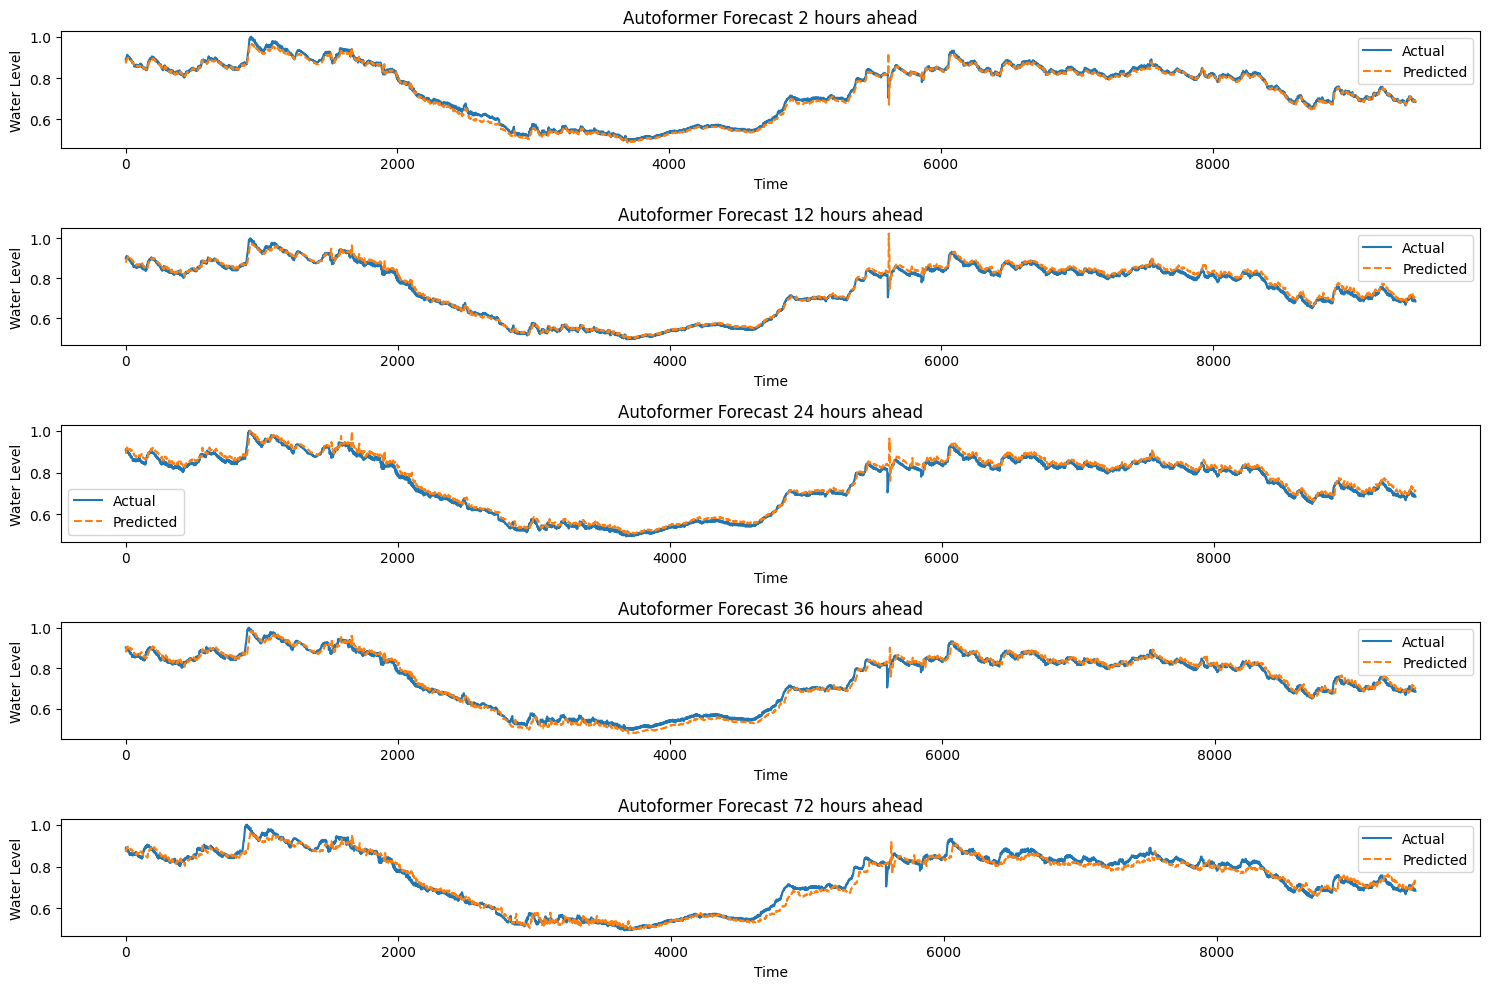

In [57]:
# Plot actual vs predicted values
plt.figure(figsize=(15, 10))
for i, step in enumerate(forecast_steps, 1):
    y_test, y_pred = predictions[step]
    plt.subplot(len(forecast_steps), 1, i)
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted', linestyle='dashed')
    plt.title(f"Autoformer Forecast {step * time_step} hours ahead")
    plt.xlabel("Time")
    plt.ylabel("Water Level")
    plt.legend()
plt.tight_layout()
plt.show()

In [59]:
# Informer Forecasting for Water Level at Station Q64 with Grid Search

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

In [60]:
!ls /kaggle/input
df = pd.read_csv("/kaggle/input/mucnuoc/mucnuoc_gio_preprocess.csv")
df.head(3)

mucnuoc  notebook48997725d8


,date,q120,q55,q64,q66,q69
0,2014-01-01 01:00:00,-0.94,-8.00,-4.58,-1.45,-9.01
1,2014-01-01 03:00:00,-0.94,-7.98,-4.57,-1.45,-9.00
2,2014-01-01 05:00:00,-0.94,-7.95,-4.58,-1.45,-9.00


In [61]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date').reset_index(drop=True)

# Feature engineering
df['lag_1'] = df['q64'].shift(1)
df['lag_2'] = df['q64'].shift(2)
df['rolling_mean_3'] = df['q64'].rolling(window=3).mean()
df['rolling_mean_5'] = df['q64'].rolling(window=5).mean()
df['volatility'] = df['q64'].rolling(window=3).std()
df.fillna(method="bfill", inplace=True)

<ipython-input-61-0a3d6e2fd727>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


In [62]:
# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.iloc[:, 1:])

# Time step configuration
time_step = (df['date'][1] - df['date'][0]).seconds // 3600  # 2 hours
forecast_hours = [2, 12, 24, 36, 72]
forecast_steps = [h // time_step for h in forecast_hours]

In [63]:
#Informer 24h
n_steps = 12  # 24 hours lookback
split = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:split], scaled_data[split:]

def create_sequences(data, target_col_index, n_steps, forecast_step):
    X, y = [], []
    for i in range(len(data) - n_steps - forecast_step):
        X.append(data[i : i + n_steps])
        y.append(data[i + n_steps + forecast_step, target_col_index])
    return np.array(X), np.array(y)

In [65]:
data_dict = {}
for step in forecast_steps:
    X_train, y_train = create_sequences(train_data, target_col_index=2, n_steps=n_steps, forecast_step=step)
    X_test, y_test = create_sequences(test_data, target_col_index=2, n_steps=n_steps, forecast_step=step)
    data_dict[step] = (X_train, y_train, X_test, y_test)


In [68]:
# Define parameter grid
param_grid = {
    'batch_size': [16, 32],
    'epochs': [10, 20],
    'learning_rate': [0.001, 0.0005],
    'num_heads': [4, 8],
    'ff_dim': [10],
}

def build_informer_model(input_shape, num_heads, ff_dim, learning_rate):
    inputs = Input(shape=input_shape)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(inputs, inputs)
    attn_output = Dropout(0.1)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)
    conv_output = Conv1D(filters=ff_dim, kernel_size=3, padding='same', activation="relu")(out1)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + conv_output)
    avg_pool = GlobalAveragePooling1D()(out2)
    outputs = Dense(1)(avg_pool)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

In [69]:
# Grid search to find best parameters
best_params = None
best_score = float('inf')
for params in ParameterGrid(param_grid):
    batch_size = params['batch_size']
    epochs = params['epochs']
    learning_rate = params['learning_rate']
    num_heads = params['num_heads']
    ff_dim = params['ff_dim']
    
    model = build_informer_model((n_steps, train_data.shape[1]), num_heads, ff_dim, learning_rate)
    X_train, y_train = data_dict[forecast_steps[0]][0:2]  # Use first step for validation
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    
    X_test, y_test = data_dict[forecast_steps[0]][2:4]
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    if mse < best_score:
        best_score = mse
        best_params = params

print("Best Parameters Informer 24h:", best_params)

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Best Parameters Informer 24h: {'batch_size': 16, 'epochs': 20, 'ff_dim': 10, 'learning_rate': 0.0005, 'num_heads': 4}


In [70]:
# Train final models with best parameters
final_models = {}
eval_metrics = {}
predictions = {}

for step, (X_train, y_train, X_test, y_test) in data_dict.items():
    model = build_informer_model((X_train.shape[1], X_train.shape[2]), best_params['num_heads'], best_params['ff_dim'], best_params['learning_rate'])
    model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(X_test, y_test), verbose=1)
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    eval_metrics[step] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}
    final_models[step] = model
    predictions[step] = (y_test, y_pred)

Epoch 1/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0552 - val_loss: 0.0013
Epoch 2/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 9.4597e-04 - val_loss: 0.0024
Epoch 3/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4.3453e-04 - val_loss: 0.0038
Epoch 4/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.6637e-04 - val_loss: 0.0030
Epoch 5/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.7995e-04 - val_loss: 0.0012
Epoch 6/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.5393e-04 - val_loss: 8.3258e-04
Epoch 7/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.2176e-04 - val_loss: 0.0017
Epoch 8/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.1011e-04 - val_loss: 0.0011
Epoch 9/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 9.6679e-05 - val_loss: 0.0017
Epoch 10/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 8.9911e-05 - val_loss: 0.0011
Epoch 11/20
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 8.3268e-05 - val

In [71]:
# Display results as table
results_df = pd.DataFrame(eval_metrics).T
results_df.index = [f"{step * time_step}h" for step in results_df.index]
print("\nComparison of Forecasting Metrics:")
print(results_df)


Comparison of Forecasting Metrics:
          MSE      RMSE       MAE        R2
2h   0.000840  0.028975  0.026258  0.950755
12h  0.000587  0.024227  0.021036  0.965564
24h  0.000349  0.018675  0.013672  0.979534
36h  0.000315  0.017739  0.012532  0.981528
72h  0.000695  0.026371  0.019783  0.959158


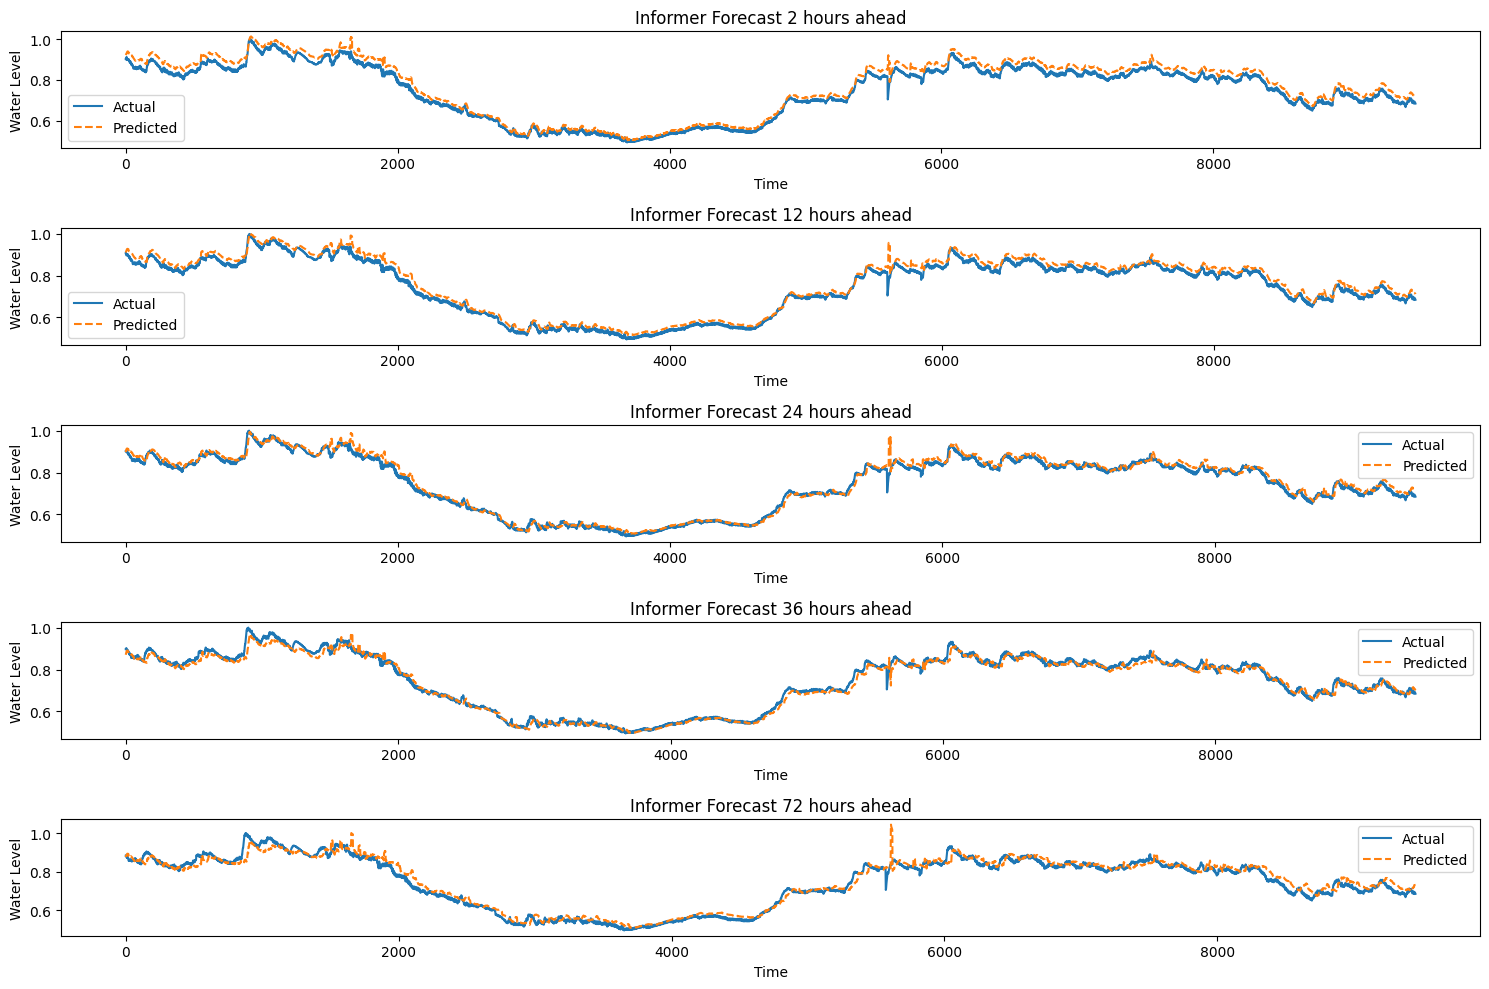

In [72]:
# Plot actual vs predicted values
plt.figure(figsize=(15, 10))
for i, step in enumerate(forecast_steps, 1):
    y_test, y_pred = predictions[step]
    plt.subplot(len(forecast_steps), 1, i)
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted', linestyle='dashed')
    plt.title(f"Informer Forecast {step * time_step} hours ahead")
    plt.xlabel("Time")
    plt.ylabel("Water Level")
    plt.legend()
plt.tight_layout()
plt.show()

In [73]:
#Informer 12h
n_steps = 6  # 12 hours lookback
split = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:split], scaled_data[split:]

def create_sequences(data, target_col_index, n_steps, forecast_step):
    X, y = [], []
    for i in range(len(data) - n_steps - forecast_step):
        X.append(data[i : i + n_steps])
        y.append(data[i + n_steps + forecast_step, target_col_index])
    return np.array(X), np.array(y)

In [75]:
data_dict = {}
for step in forecast_steps:
    X_train, y_train = create_sequences(train_data, target_col_index=2, n_steps=n_steps, forecast_step=step)
    X_test, y_test = create_sequences(test_data, target_col_index=2, n_steps=n_steps, forecast_step=step)
    data_dict[step] = (X_train, y_train, X_test, y_test)


In [76]:
# Define parameter grid
param_grid = {
    'batch_size': [16, 32],
    'epochs': [10, 20],
    'learning_rate': [0.001, 0.0005],
    'num_heads': [4, 8],
    'ff_dim': [10],
}

def build_informer_model(input_shape, num_heads, ff_dim, learning_rate):
    inputs = Input(shape=input_shape)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(inputs, inputs)
    attn_output = Dropout(0.1)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)
    conv_output = Conv1D(filters=ff_dim, kernel_size=3, padding='same', activation="relu")(out1)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + conv_output)
    avg_pool = GlobalAveragePooling1D()(out2)
    outputs = Dense(1)(avg_pool)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

In [77]:
# Grid search to find best parameters
best_params = None
best_score = float('inf')
for params in ParameterGrid(param_grid):
    batch_size = params['batch_size']
    epochs = params['epochs']
    learning_rate = params['learning_rate']
    num_heads = params['num_heads']
    ff_dim = params['ff_dim']
    
    model = build_informer_model((n_steps, train_data.shape[1]), num_heads, ff_dim, learning_rate)
    X_train, y_train = data_dict[forecast_steps[0]][0:2]  # Use first step for validation
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    
    X_test, y_test = data_dict[forecast_steps[0]][2:4]
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    if mse < best_score:
        best_score = mse
        best_params = params

print("Best Parameters Informer 12h:", best_params)

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Best Parameters Informer 12h: {'batch_size': 32, 'epochs': 20, 'ff_dim': 10, 'learning_rate': 0.0005, 'num_heads': 8}


In [78]:
# Train final models with best parameters
final_models = {}
eval_metrics = {}
predictions = {}

for step, (X_train, y_train, X_test, y_test) in data_dict.items():
    model = build_informer_model((X_train.shape[1], X_train.shape[2]), best_params['num_heads'], best_params['ff_dim'], best_params['learning_rate'])
    model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(X_test, y_test), verbose=1)
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    eval_metrics[step] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}
    final_models[step] = model
    predictions[step] = (y_test, y_pred)

Epoch 1/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0297 - val_loss: 0.0011
Epoch 2/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.0306e-04 - val_loss: 5.0134e-04
Epoch 3/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.4839e-04 - val_loss: 4.4346e-04
Epoch 4/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.0784e-04 - val_loss: 2.1462e-04
Epoch 5/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.4705e-04 - val_loss: 3.1082e-04
Epoch 6/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.9034e-04 - val_loss: 3.9433e-04
Epoch 7/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6706e-04 - val_loss: 1.4499e-04
Epoch 8/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4544e-04 - val_loss: 1.6072e-04
Epoch 9/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2105e-04 - val_loss: 9.3101e-04
Epoch 10/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1516e-04 - val_loss: 1.1678e-04
Epoch 11/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 2s 2

In [79]:
# Display results as table
results_df = pd.DataFrame(eval_metrics).T
results_df.index = [f"{step * time_step}h" for step in results_df.index]
print("\nComparison of Forecasting Metrics:")
print(results_df)


Comparison of Forecasting Metrics:
          MSE      RMSE       MAE        R2
2h   0.000429  0.020722  0.018134  0.974816
12h  0.000235  0.015343  0.012389  0.986192
24h  0.000193  0.013899  0.009902  0.988666
36h  0.000335  0.018312  0.014139  0.980321
72h  0.000662  0.025739  0.019111  0.961098


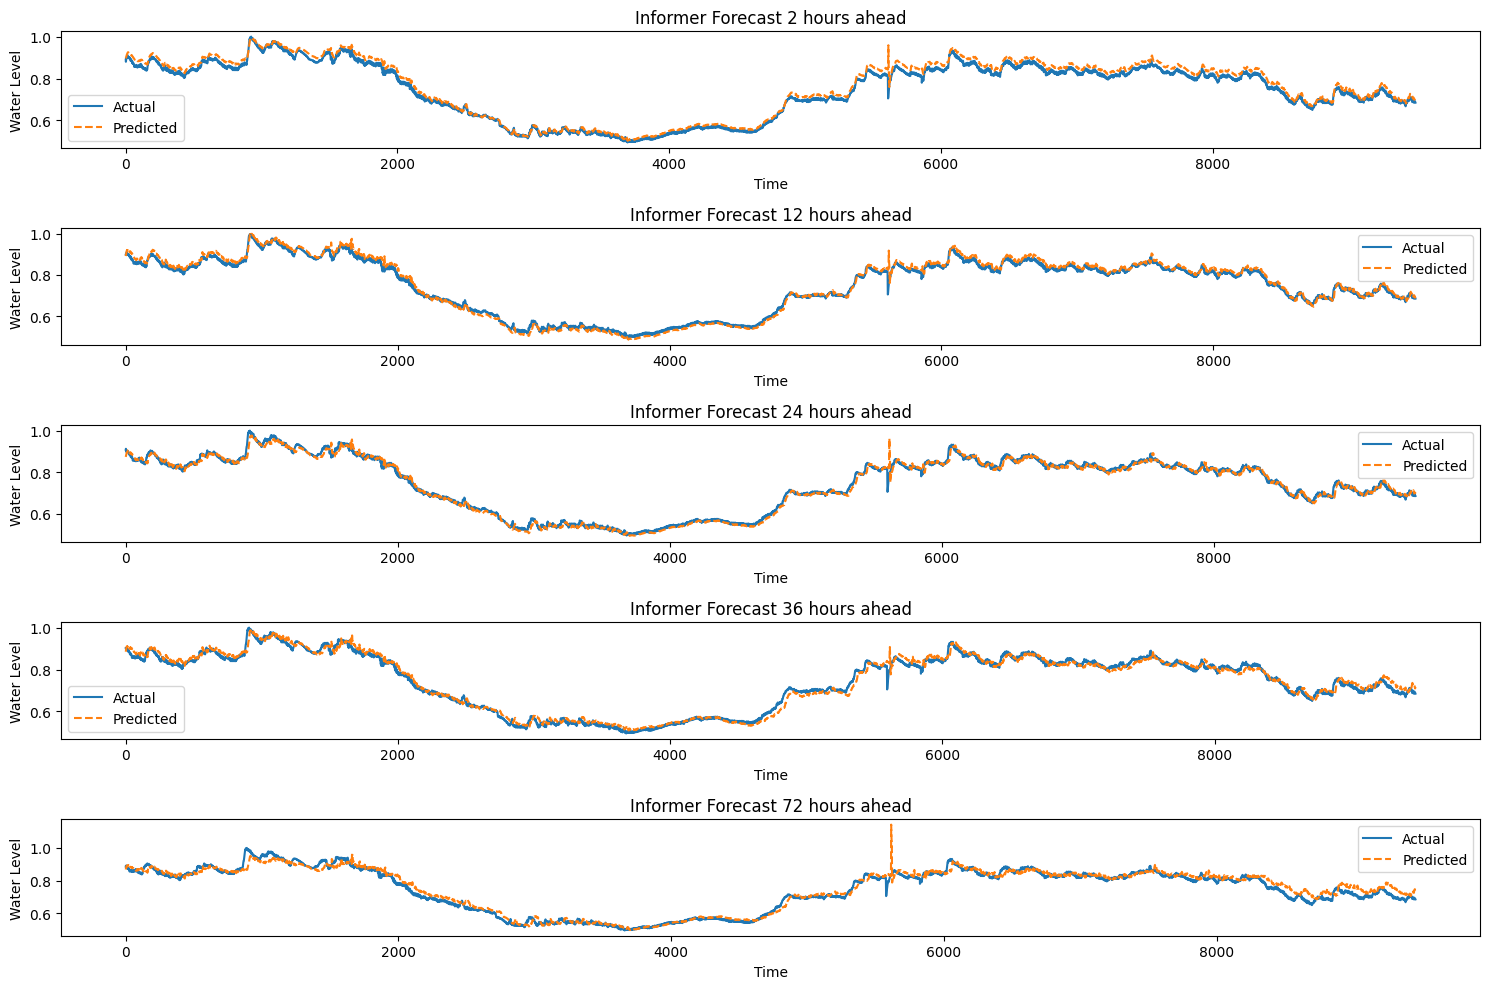

In [80]:
# Plot actual vs predicted values
plt.figure(figsize=(15, 10))
for i, step in enumerate(forecast_steps, 1):
    y_test, y_pred = predictions[step]
    plt.subplot(len(forecast_steps), 1, i)
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted', linestyle='dashed')
    plt.title(f"Informer Forecast {step * time_step} hours ahead")
    plt.xlabel("Time")
    plt.ylabel("Water Level")
    plt.legend()
plt.tight_layout()
plt.show()